### Bayesian optimization: Automating experimental optimization

In [15]:
import numpy as np
import scipy 
import scipy.stats
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from e4e import E4E 

e4e = E4E(chapter=6)

#### Optimize a single compiler parameter, a visual explanation

Bayesian optimization improves on response surface methodology by combining taking measurements, balancing exploration with exploration, and the use of a surrogate function which is continously optimized. Bayesian optimization doesnt require the engineer to specify the form of a surrogate function, as its fully automated. Bayesian optimization is also able to optimize a lot more continuous parameters than response surface methodology.  Bayseian optimization uses a surrogate function called Gaussian process regression. Bayesian optimization is an example of a black box optimizer, because it adjusts many continuous parameters of systems whose inner workings are unknown.

The engineer defines the ranges of all the continuous parameters that need optimization. Bayesian optimization starts in the center of the parameter space, and decides which direction to go from there to optimize the business metric. When a measurement is taken with the initial center values, a response surface function is modeled with the measurement. Also, the uncertainty is least at the point of measurement and increases the further away one goes from the parameter. Bayesian optimization uses an acquisition function to choose the next point of measurement, to balance exploration and exploitation. An example of an acquisition function used below is the min (cpu_time - model_uncertainity). This balance of exploitation, (choosing the minimum cpu_time), and exploration (choosing the highest model_uncertainty), ensures that the business metric is optimized during experimentation. The surrogate function used, Gaussian process regression, models the response function using the measurements taken. Then for each parameter value in a range, the model estimates the business metric and the associated uncertainty.

In [16]:
def jit_plus_server(parameters):            # parameters is a values for set of parameters that affect cpu_time
    x = np.array(parameters)                # parameters in numpy array
    d = x.shape                             # size of parameters
    x1 = x - 0.15*np.ones(shape=d)       # first set of values obtained from parameters, x - 0.15
    x2 = x - 0.85*np.ones(shape=d)       # second set of values obtained from parameters, x - 0.85
    cpu_time = 2 - np.exp(-10*x1**2) - 0.5*np.exp(-10*x2**2)  # complex function of parameters, vector
    return cpu_time.mean() + .005*np.random.normal()          # cpu_time from vector d, add random variation

In [17]:
# Start by assuming only one parameter
np.random.seed(17)
jit_plus_server([0.5])

1.5607447789648075

#### Analyze: Model the response surface

In [18]:
# Analyze: Model response surface
class GPR_viz:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters                     # assign the parameters as attribute x
        self.y = np.array(measurements)         # assign the measured cpu times as attribute y
        self.sigma = sigma                      # sigma for kernel trick

        self.mean_y = self.y.mean()             # mean of meaasurements, estimate or expectation
        if len(self.y) > 1:
            self.std_y = self.y.std()           # obtain the standard deviation of measurements
        else:
            self.std_y = 1                      # for len(y) == 0 or len(y) == 1, set std at 1
        self.y -= self.mean_y                   # de-mean, to center measurements at mean of 0

    def kernel(self, x1, x2):       # the kernel function replaces the dot product in kernel trick
        distance_squared = ((x1-x2)**2).sum()   # euclidean distance
        return np.exp( -distance_squared/(2*self.sigma**2)) # radial basis kernel function
    
    def estimate(self, query_parameter):        
        kernels_x_query = np.array([            # for every parameter 
            self.kernel(x, query_parameter)     # get the rbf ie similarity score with query parameter
            for x in self.x                     # 1 for very similar, 0 for dissimilar
        ])          # row vector where ith value is similarity score of ith parameter with query parameter

        kernels_x_x = np.array([
            [
                self.kernel(x1, x2)             # get rbf ie similarity score among the original parameters
                for x1 in self.x    
            ]
            for x2 in self.x            
        ])          # matrix where ith row is the similarity scores of ith parameter with others

        weights = kernels_x_query.T @ np.linalg.pinv(kernels_x_x)   # weights (lin. regr. kernel for dot)
        expectation = self.mean_y + weights @ self.y                # self.y is de-meaned
        uncertainty_squared = 1 - weights @ kernels_x_query         # standard error of aggregate measurement?
        return expectation, self.std_y * np.sqrt(np.maximum(0, uncertainty_squared))

In [1]:
def plot_example_gpr(GPR, ax, x, y, err_bars=False, bottom_trace=False):
    x = np.array(x)                         # parameters as ndarray
    y = np.array(y)                         # measurements as ndarray
    gpr = GPR(x, y, sigma=0.15)             # build GPR viz class surrogate function (radial basis) 
    x_hats = np.linspace(0, 1, 100)         # query parameters for surrogate function b.m estimates
    y_hats = []                             # business metric estimates from surrogate function
    sigma_y_hats = []                       # standard error of estimate
    for x_hat in x_hats:                    # for each parameter value in range, estima
        ret = gpr.estimate(x_hat)           # estimate business metric value for parameter using model
        try:
            y_hat, sigma_y_hat = ret        # expectation of measurement, standard error of measurement
        except:
            y_hat = ret                     # single measurement's expectation
            sigma_y_hat = 0                 # single measurement's standard error
        y_hats.append(y_hat)                # store expectation?
        sigma_y_hats.append(sigma_y_hat)    # store standard error?

    y_hats = np.array(y_hats)               # expecations? as ndarray
    sigma_y_hats = np.array(sigma_y_hats)   # standard error? as ndarray

    if err_bars:                                            # plot fill between for variation
        ax.fill_between(x_hats.flatten(),
                        y_hats - sigma_y_hats,
                        y_hats + sigma_y_hats,
                        color=e4e.color_4,
                        linewidth=1)
        
    ax.plot(x, y, 'o', color=e4e.color_1, markersize=5)     # plot parameters vs measurements
    ax.plot(x_hats, y_hats, ':', color=e4e.color_2)         # plot query parameters vs expectations?

    if bottom_trace:
        y_bots = y_hats - sigma_y_hats 
        ax.plot(x_hats, y_bots, color=e4e.color_1, linewidth=2)

0.5 1.5607447789648075


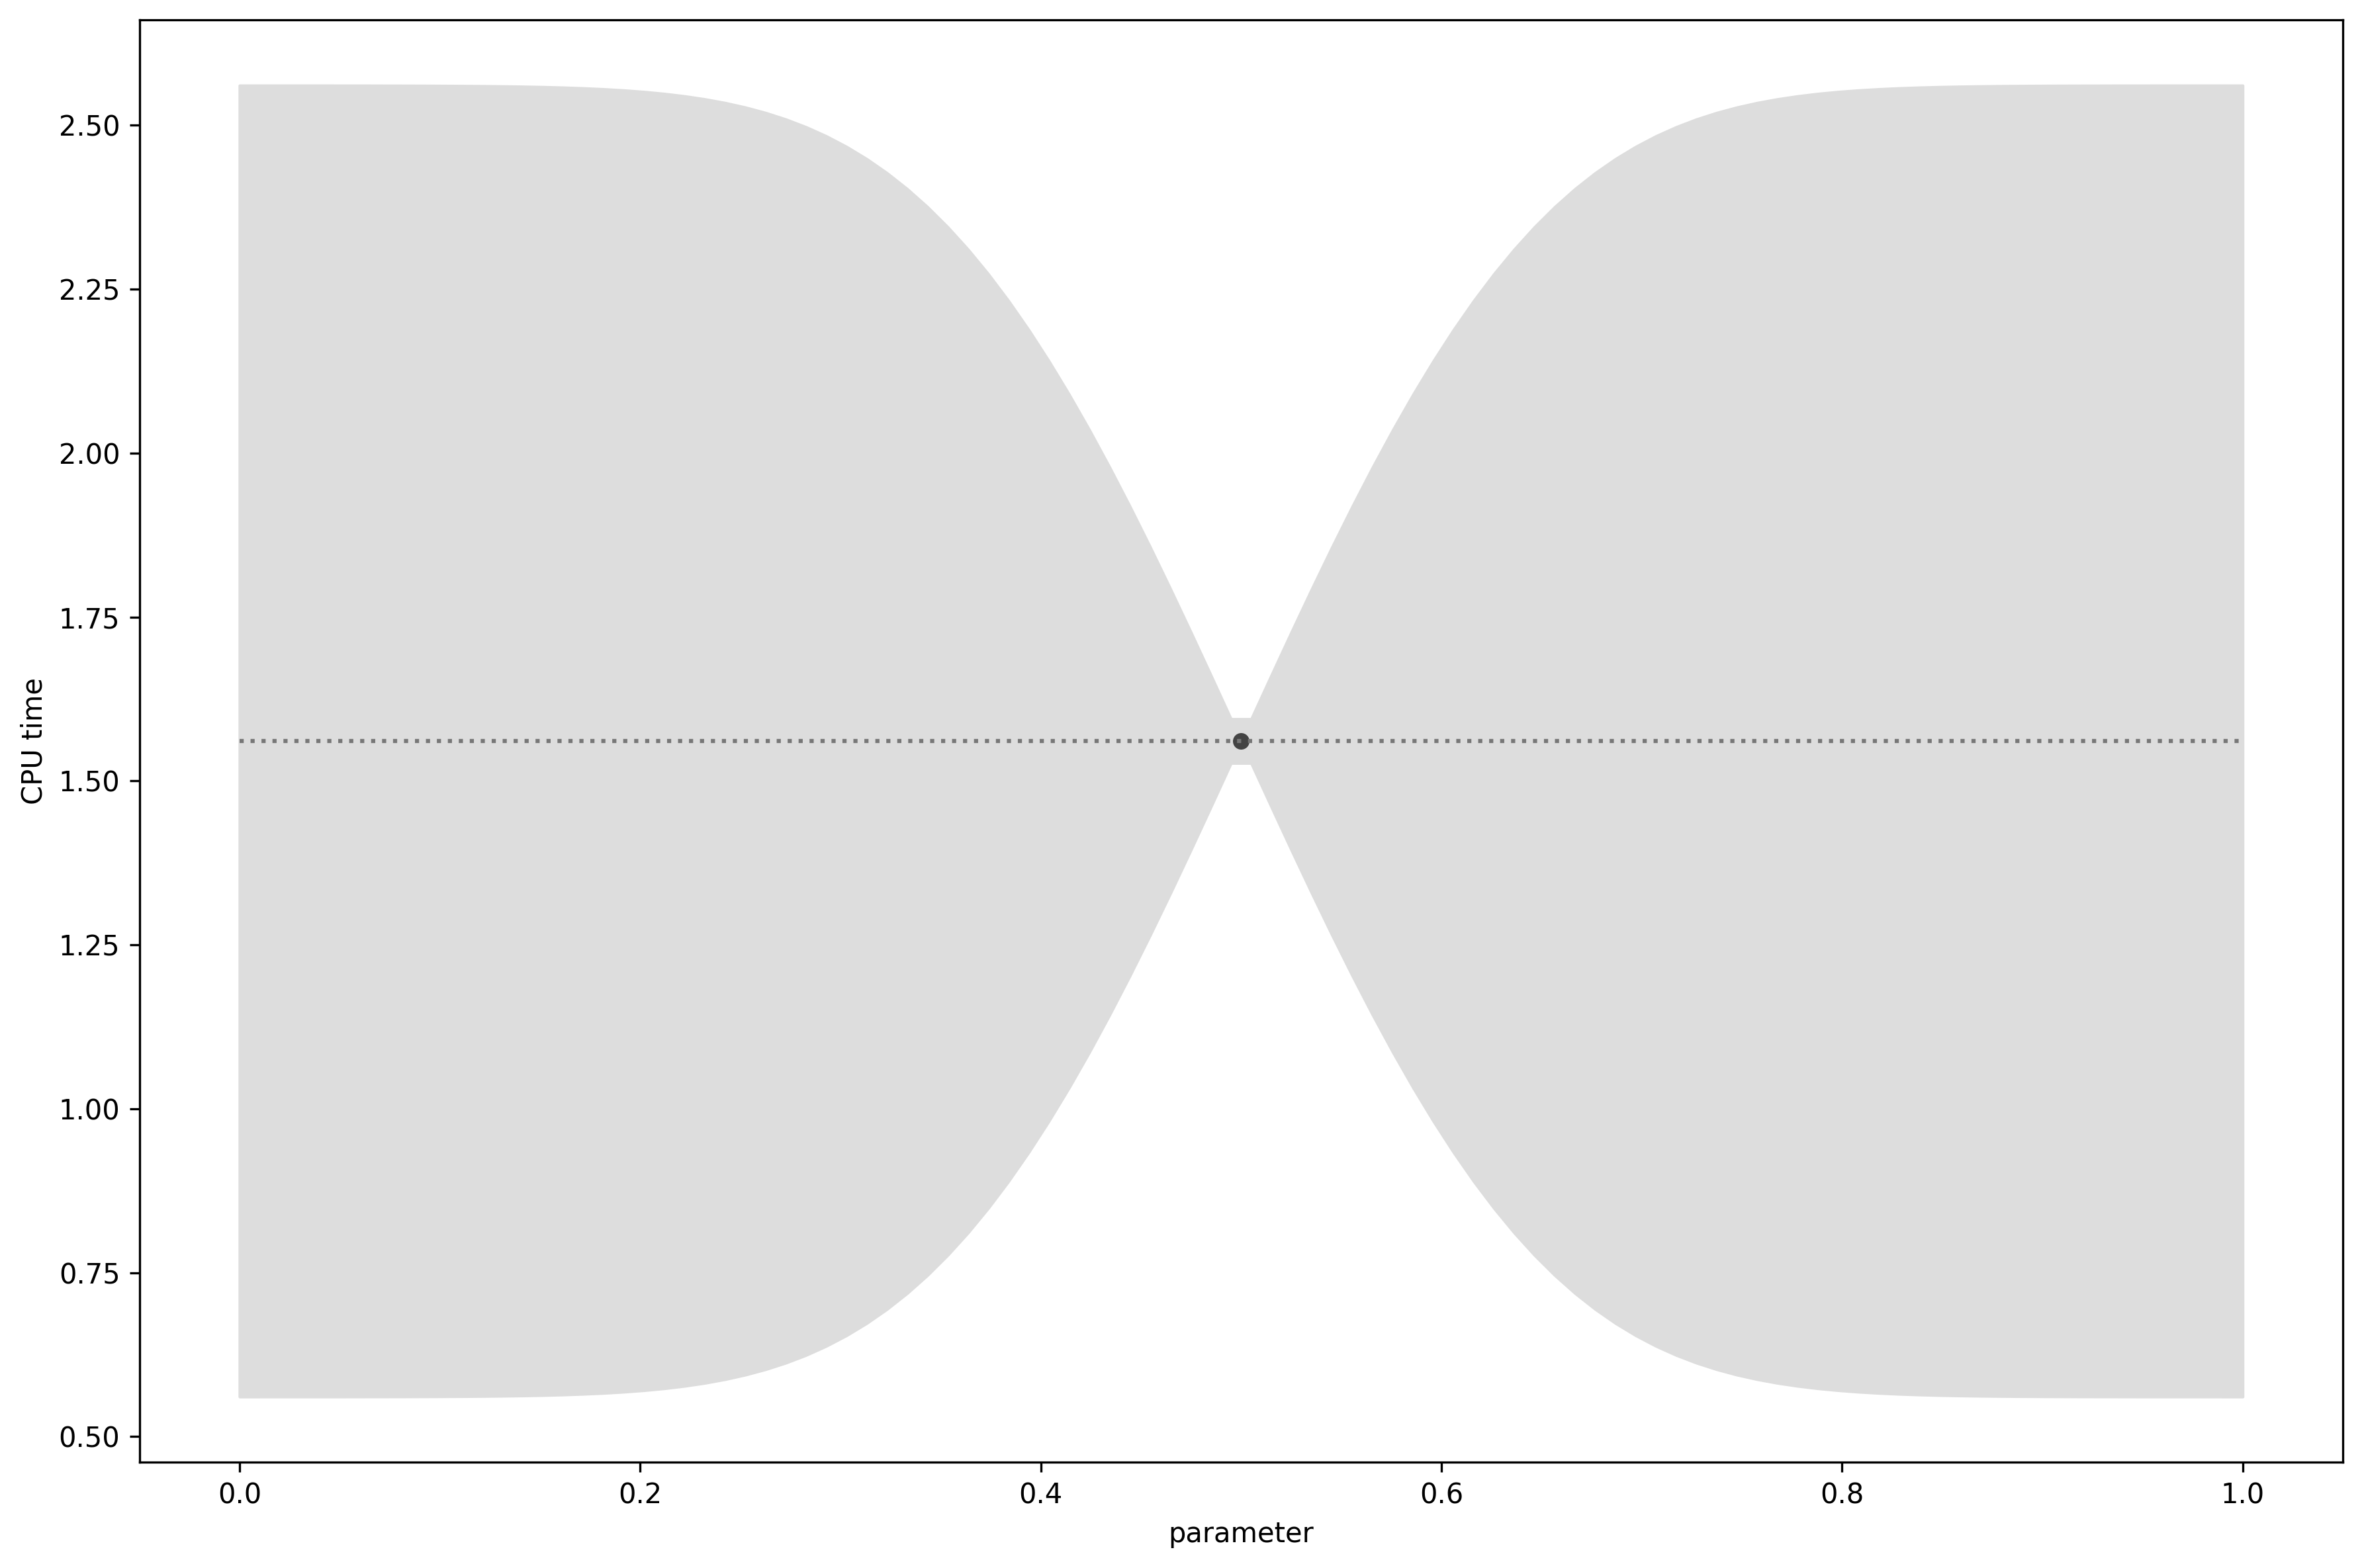

In [20]:
np.random.seed(17)                              # seed random number generator for reproducibility
parameter0 = 0.5                                # center of search space for first measurement
cpu_time0 = jit_plus_server([parameter0])       # get measurements for parameter values

print(parameter0, cpu_time0)                    

plt.figure(figsize=(12,8))
ax = plt.gca()                                  # get current axes
plot_example_gpr(GPR_viz, ax, [parameter0], [cpu_time0], err_bars=True)
plt.xlabel('parameter')
plt.ylabel('CPU time')

plt.tight_layout()
plt.show()

#### Design: Select the parameter value to measure next

In [21]:
# Measurement at the point of highest uncertainty
np.random.seed(17)
parameter1 = 0
cpu_time1 = jit_plus_server([parameter1])
print(cpu_time1)

1.2025010344211848


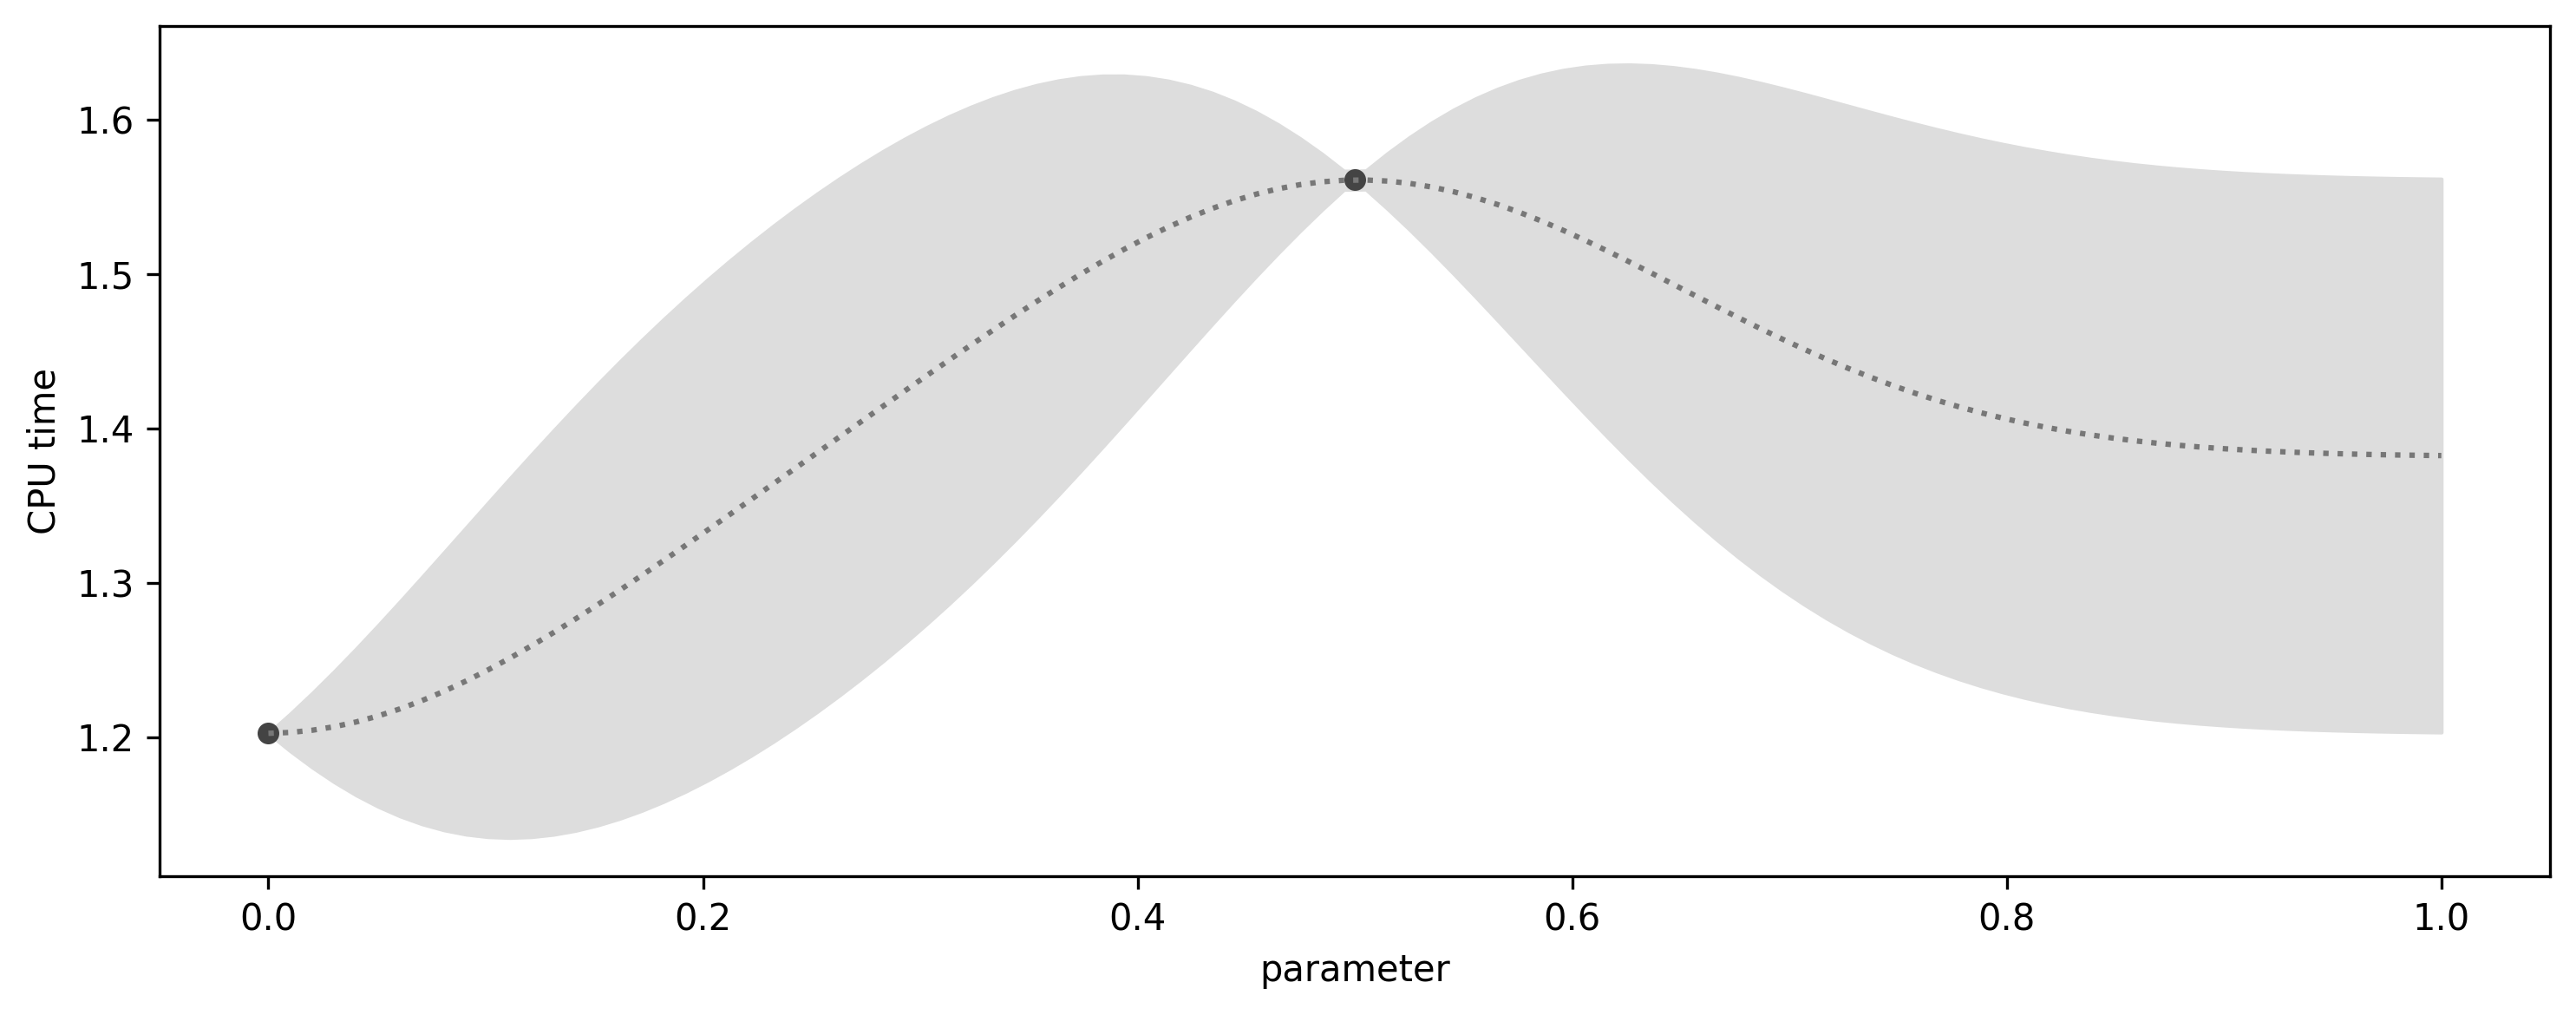

In [22]:
plt.figure(figsize=(10,4))
ax = plt.gca()
plot_example_gpr(
    GPR_viz,
    ax,
    np.array([parameter0, parameter1]),     # two parameters used to build model from surrogate function
    np.array([cpu_time0, cpu_time1]),       # measurements at the two parameters
    err_bars=True
)
plt.xlabel('parameter')
plt.ylabel('CPU time')

plt.tight_layout()
plt.show()

#### Design: Balance exploration with exploitation

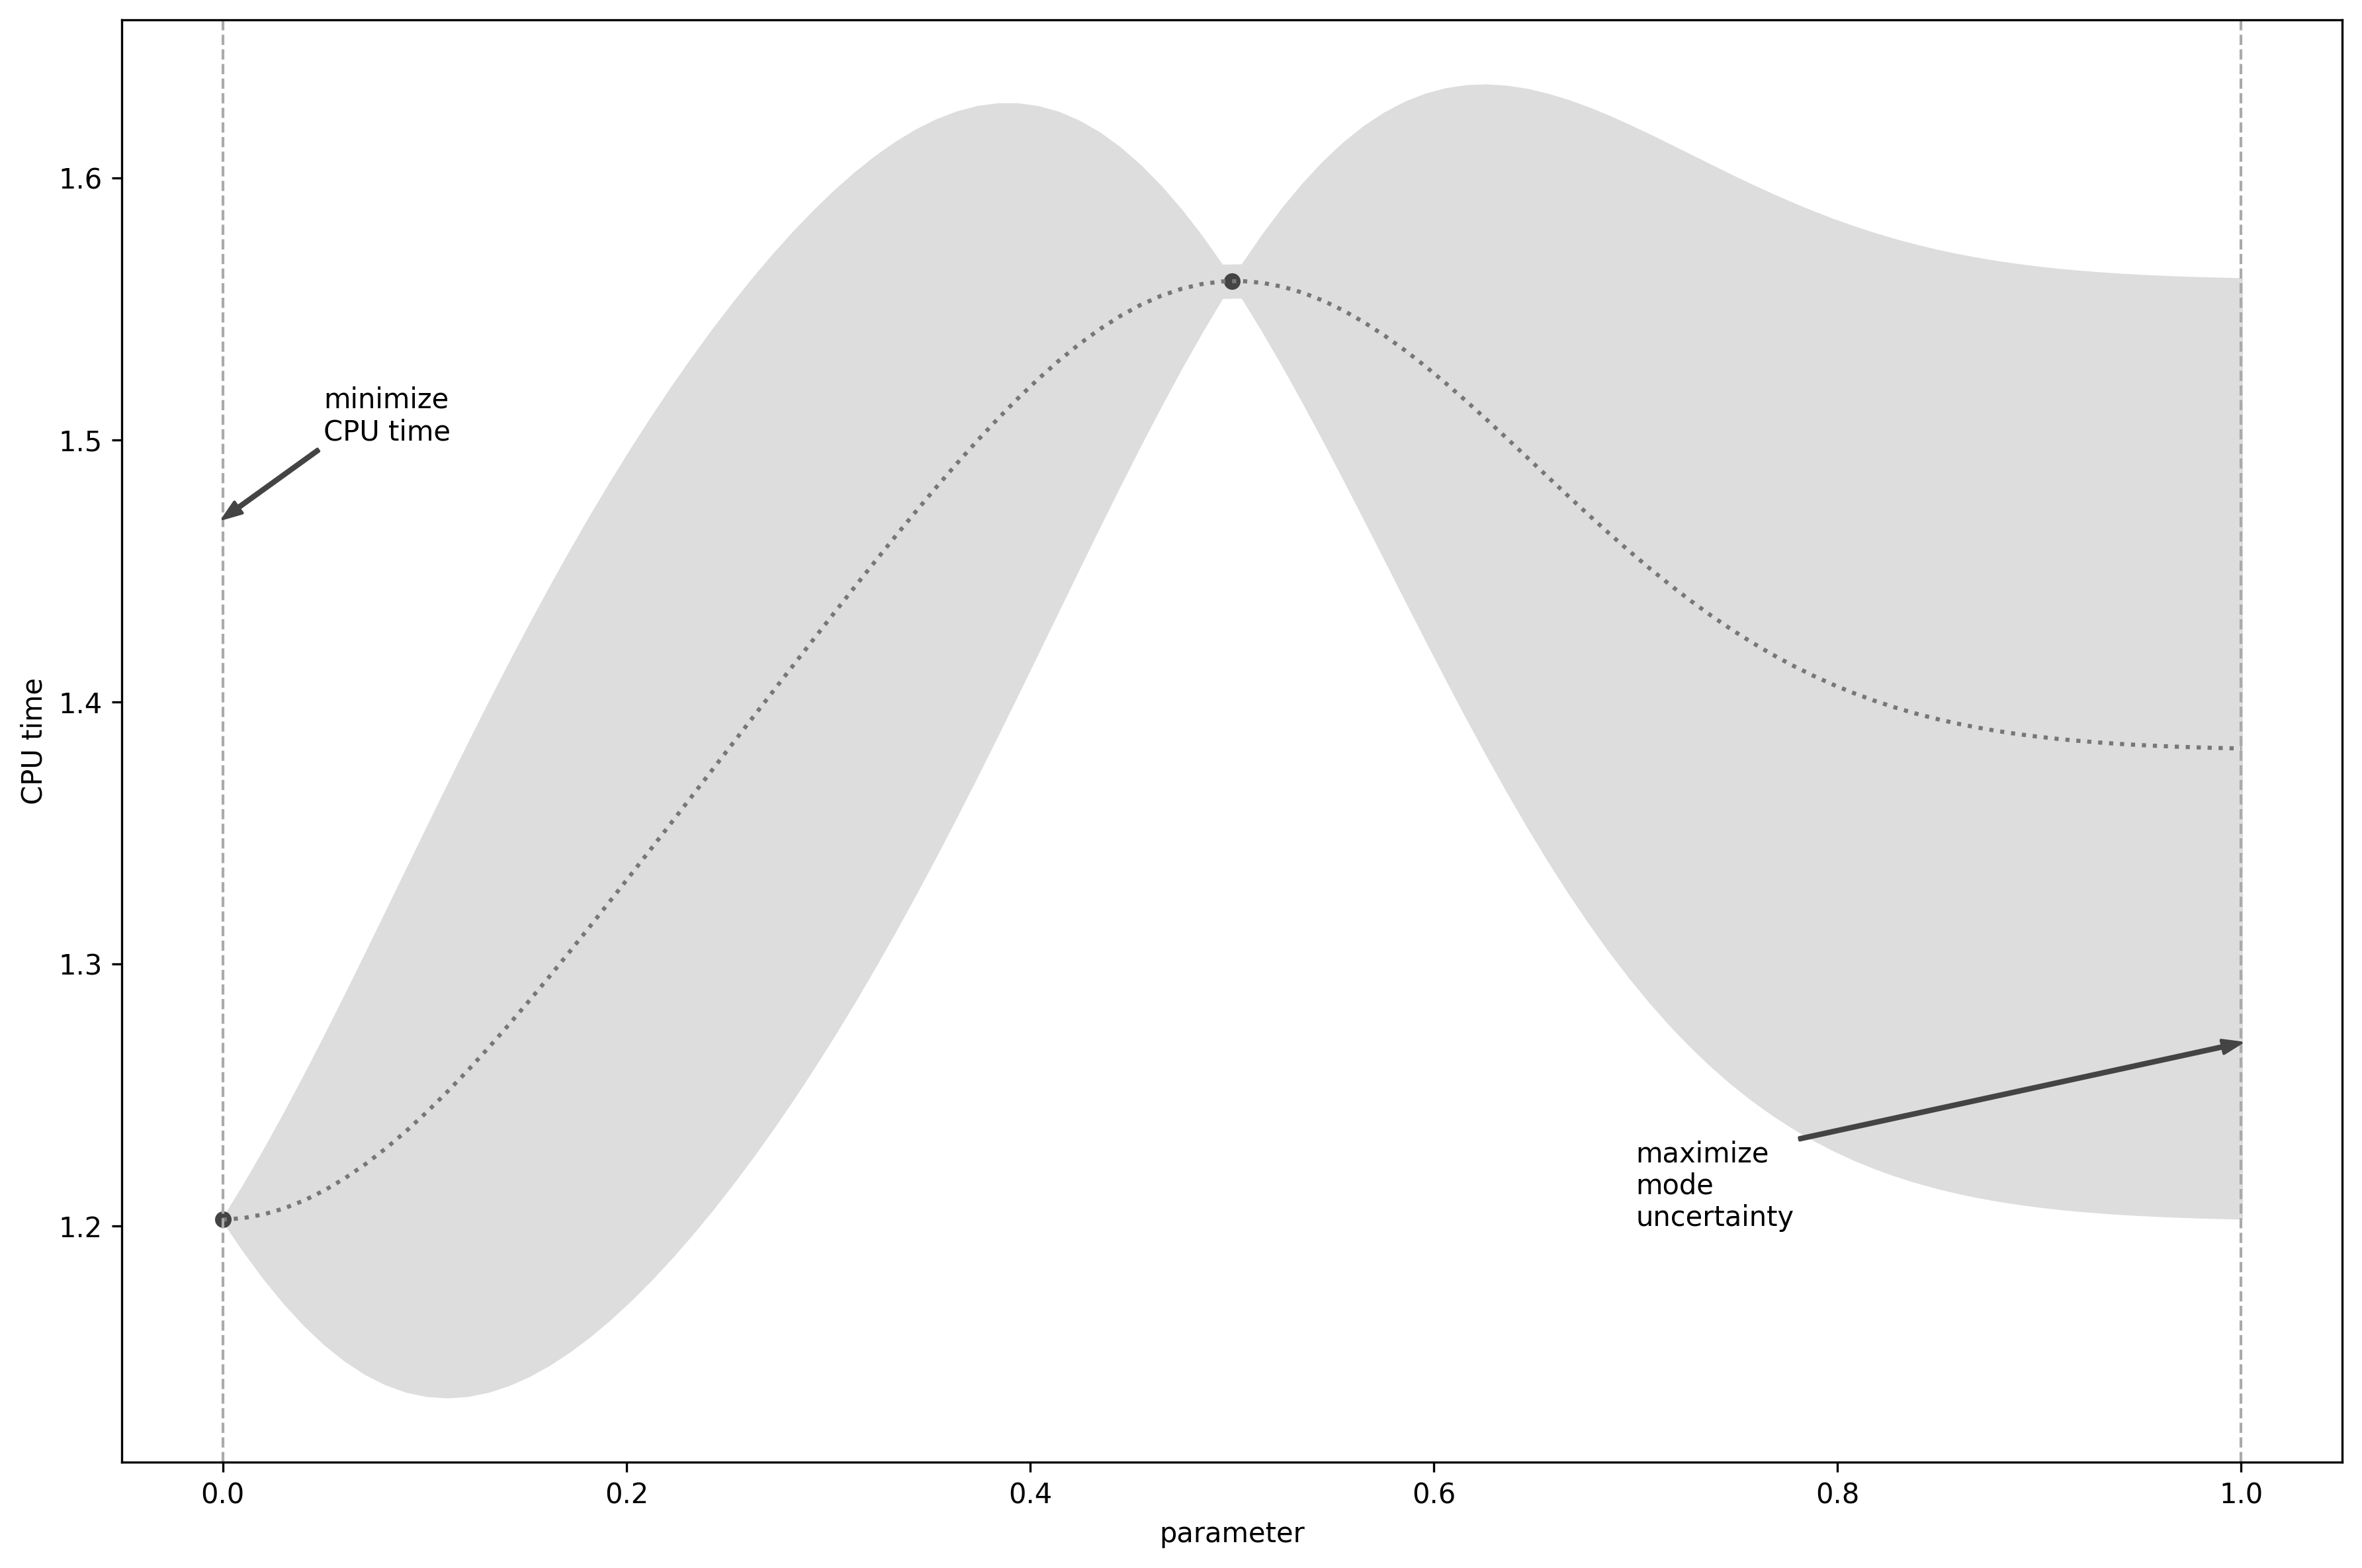

In [23]:
plt.figure(figsize=(12,8))
ax = plt.gca()
plot_example_gpr(
    GPR_viz,
    ax,
    np.array([parameter0, parameter1]),
    np.array([cpu_time0, cpu_time1]),

    err_bars = True
)
plt.xlabel('parameter')
plt.ylabel('CPU time')

e4e.vertical_line(0)
e4e.vertical_line(1)

plt.annotate("minimize\nCPU time", xy=[0, 1.47],
             xytext=[.05, 1.5],
             arrowprops=e4e.arrow_props)
plt.annotate("maximize\nmode\nuncertainty", xy=[1, 1.27],
             xytext=[.7, 1.2],
             arrowprops=e4e.arrow_props)
plt.tight_layout()
plt.show()

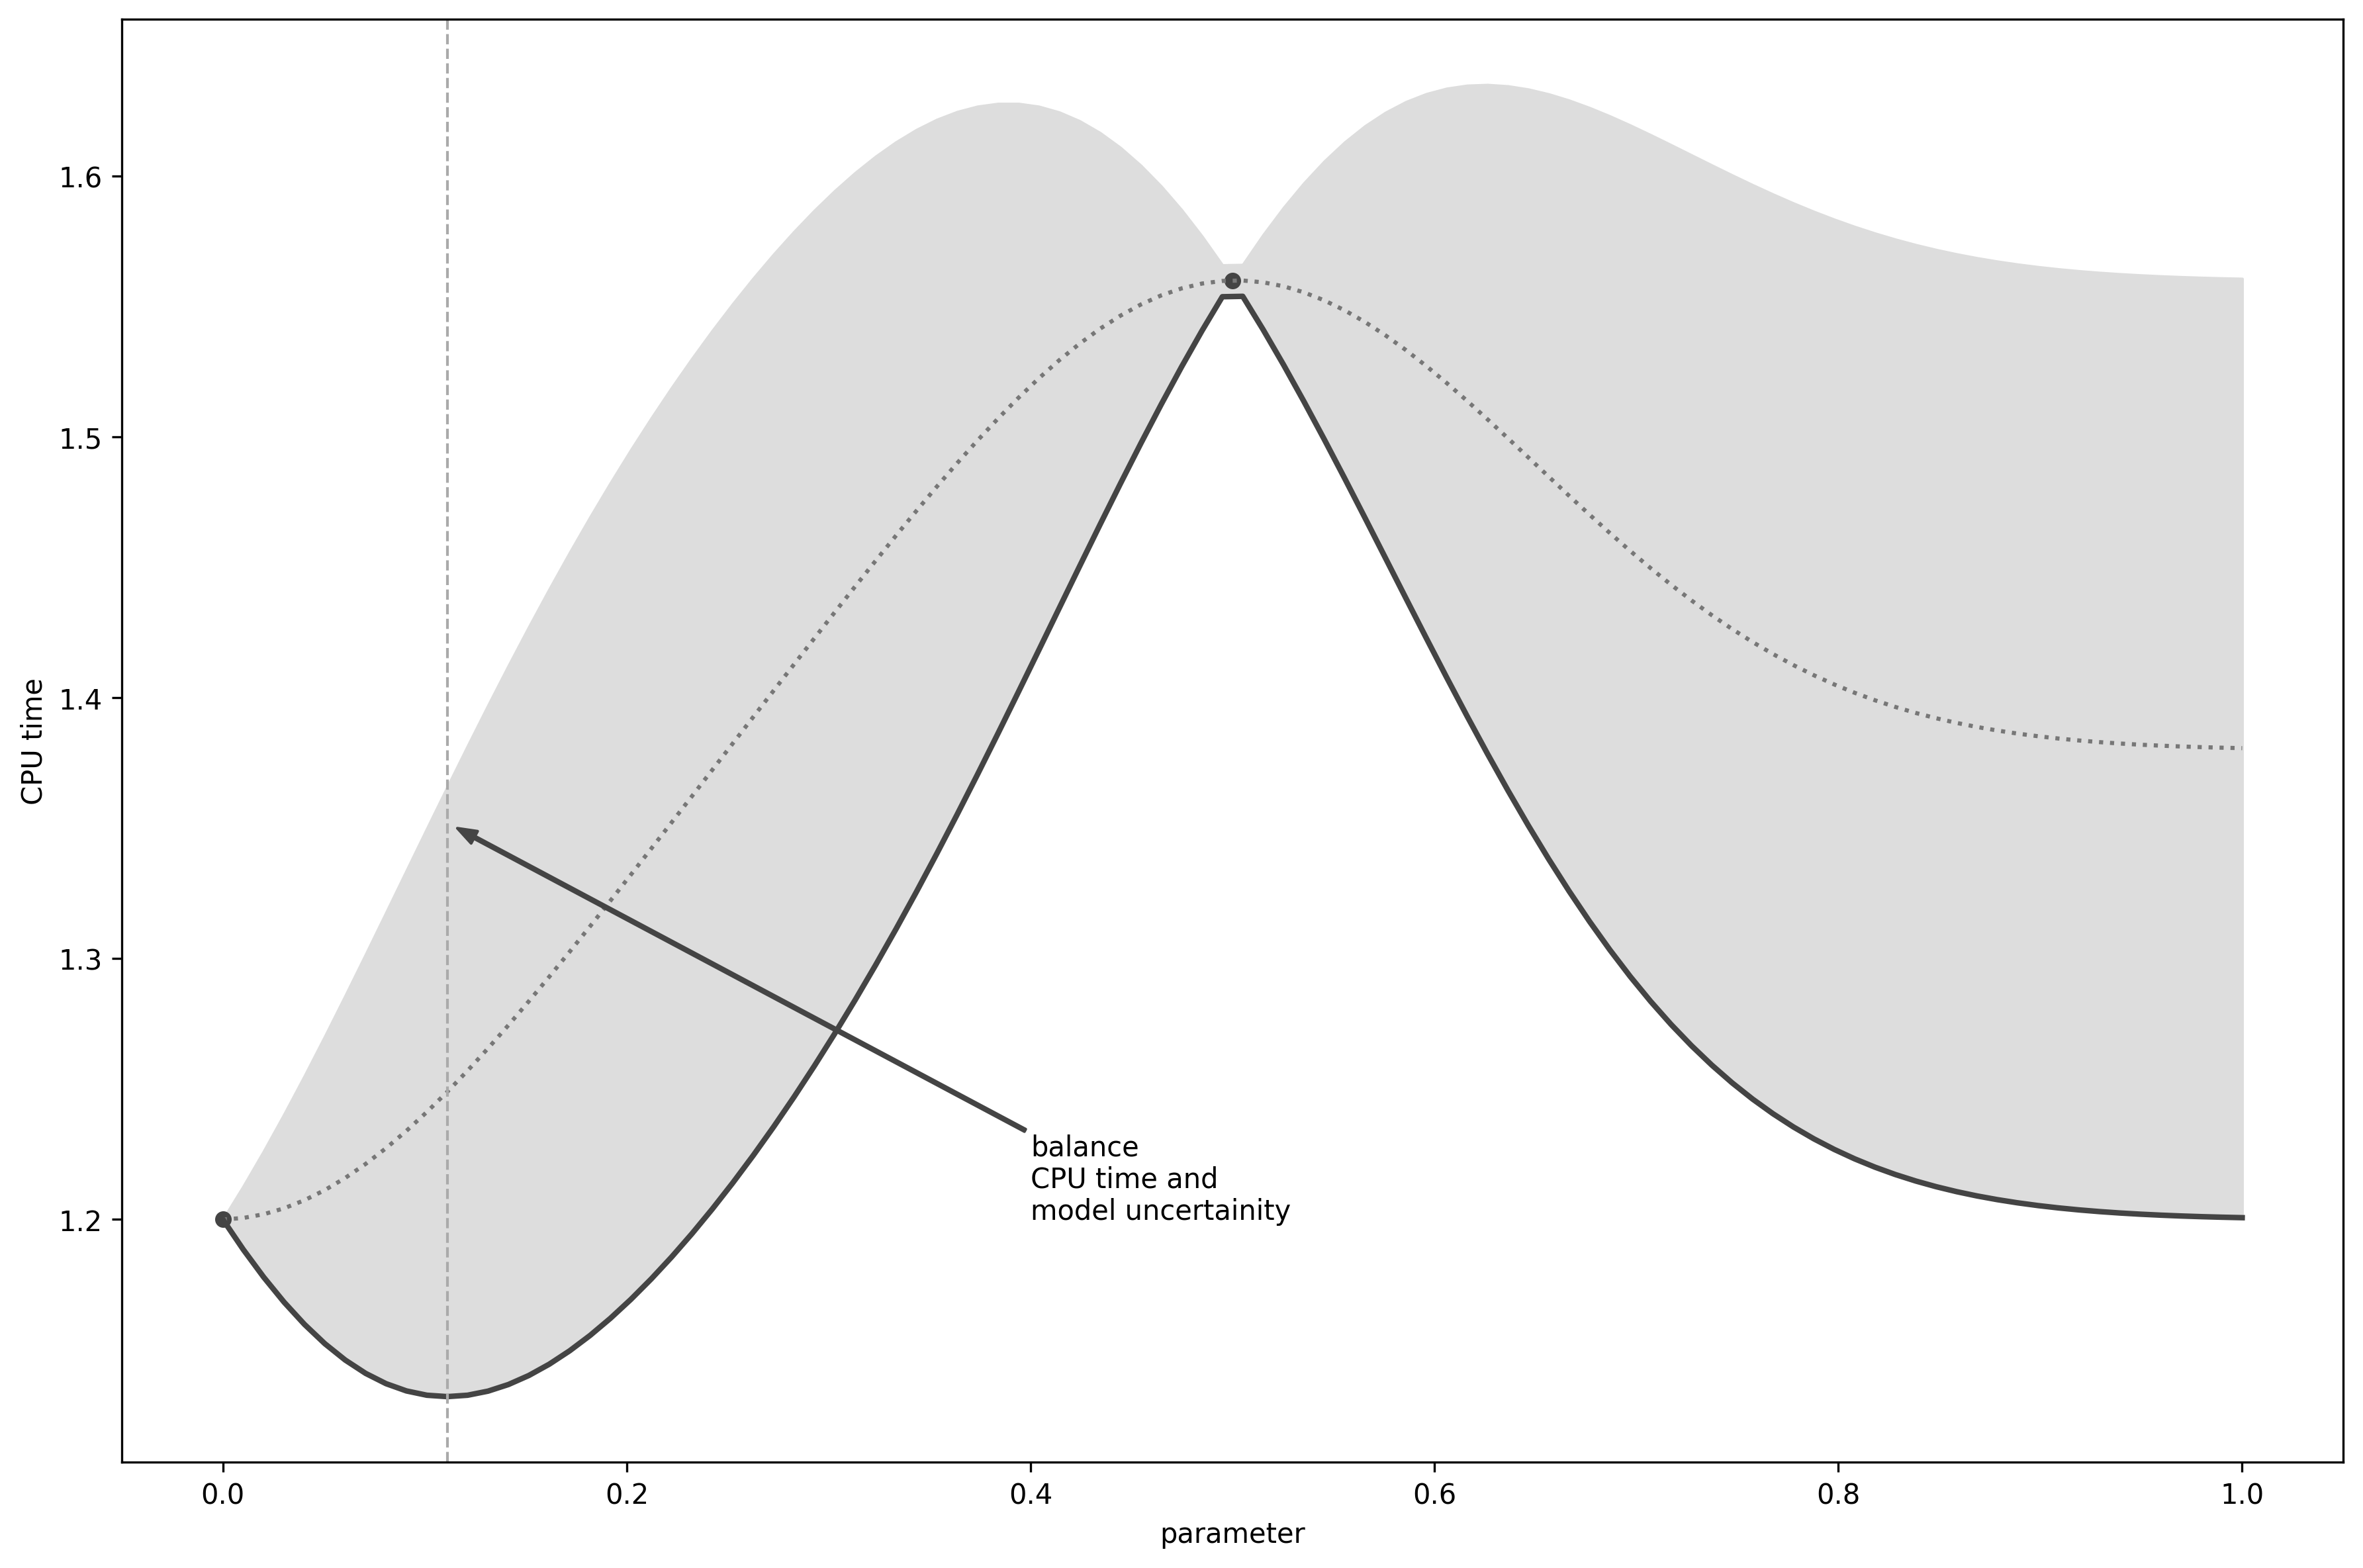

In [24]:
plt.figure(figsize=(12,8))
ax = plt.gca()
plot_example_gpr(
    GPR_viz,
    ax,
    np.array([.5, 0]),
    np.array([1.56, 1.20]),
    err_bars=True,
    bottom_trace=True
)
plt.xlabel('parameter')
plt.ylabel('CPU time')

e4e.vertical_line(.1111111)

plt.annotate("balance\nCPU time and\nmodel uncertainity",
             xy=[.111111 + .005, 1.35],
             xytext=[.4, 1.2],
             arrowprops=e4e.arrow_props)
plt.tight_layout()
plt.show()

In [25]:
# Using an acquisition function to design the next experiment
np.random.seed(17)
parameterset = [0.5]                        # initially start with centre value of parameter ranges
for i in range(10):
    parameters = np.array(parameterset)     # cast as numpy nd array to use numpy methods
    measurements = [jit_plus_server(parameter) for parameter in parameters]  # measurements at chosen params
    gpr = GPR_viz(parameters, measurements, sigma=.15) # build the GPR model
    x_hats = np.linspace(0, 1, 100)         # parameter values for business metric estimation
    y_hats = np.array([gpr.estimate(x_hat) for x_hat in x_hats]) # estimate (business metric, se) with model
    lcb = y_hats[:,0] - y_hats[:,1]         # acquisition function, business metric estimate - se
    i = np.where(lcb == lcb.min())[0]       # optimal value of acquisition function, min(estimate - se)
    if len(i) > 1:                          # if there are multiple optimal values
        i = np.array([i[0]])                # select the first optimal value
    parameterset.extend(list(x_hats[i]))
    print(f"next point : {x_hats[i][0]:.2f},  "
          f"cpu_time : {jit_plus_server(x_hats[i][0]):.2f}")   # value at optimal of aquisition function
    j = np.where(np.array(measurements) == np.array(measurements).min())
    print(f"optimal parameter : {parameters[j][0]:.2f}, "
          f"cpu_time : {np.array(measurements)[j][0]:.2f}")

next point : 0.00,  cpu_time : 1.19
optimal parameter : 0.50, cpu_time : 1.56
next point : 0.11,  cpu_time : 1.02
optimal parameter : 0.00, cpu_time : 1.21
next point : 0.20,  cpu_time : 1.02
optimal parameter : 0.11, cpu_time : 1.01
next point : 1.00,  cpu_time : 1.60
optimal parameter : 0.20, cpu_time : 1.01
next point : 0.16,  cpu_time : 1.00
optimal parameter : 0.20, cpu_time : 1.02
next point : 0.15,  cpu_time : 0.99
optimal parameter : 0.16, cpu_time : 1.00
next point : 0.16,  cpu_time : 1.00
optimal parameter : 0.16, cpu_time : 1.00
next point : 0.64,  cpu_time : 1.59
optimal parameter : 0.16, cpu_time : 0.99
next point : 0.05,  cpu_time : 1.09
optimal parameter : 0.16, cpu_time : 0.99
next point : 0.15,  cpu_time : 0.99
optimal parameter : 0.16, cpu_time : 0.99


In [26]:
parameters = np.array([0.5, 0, 0.111, .2020, 1.0, .1515])
measurements = [1.56, 1.20, 1.0036, 1.02231, 1.598, .99696]
gpr = GPR_viz(parameters, measurements, sigma=.15)
x_hats = np.linspace(0, 1, 100)
y_hats = np.array([gpr.estimate(x_hat) for x_hat in x_hats])
lcb = y_hats[:,0] - y_hats[:,1]         # acquisition function
i = np.where(lcb == lcb.min())[0]       # optimal value of acquisition function
print(x_hats[i], jit_plus_server(x_hats[i]))        # value at optimal of aquisition function

[0.14141414] 0.9988606459243535


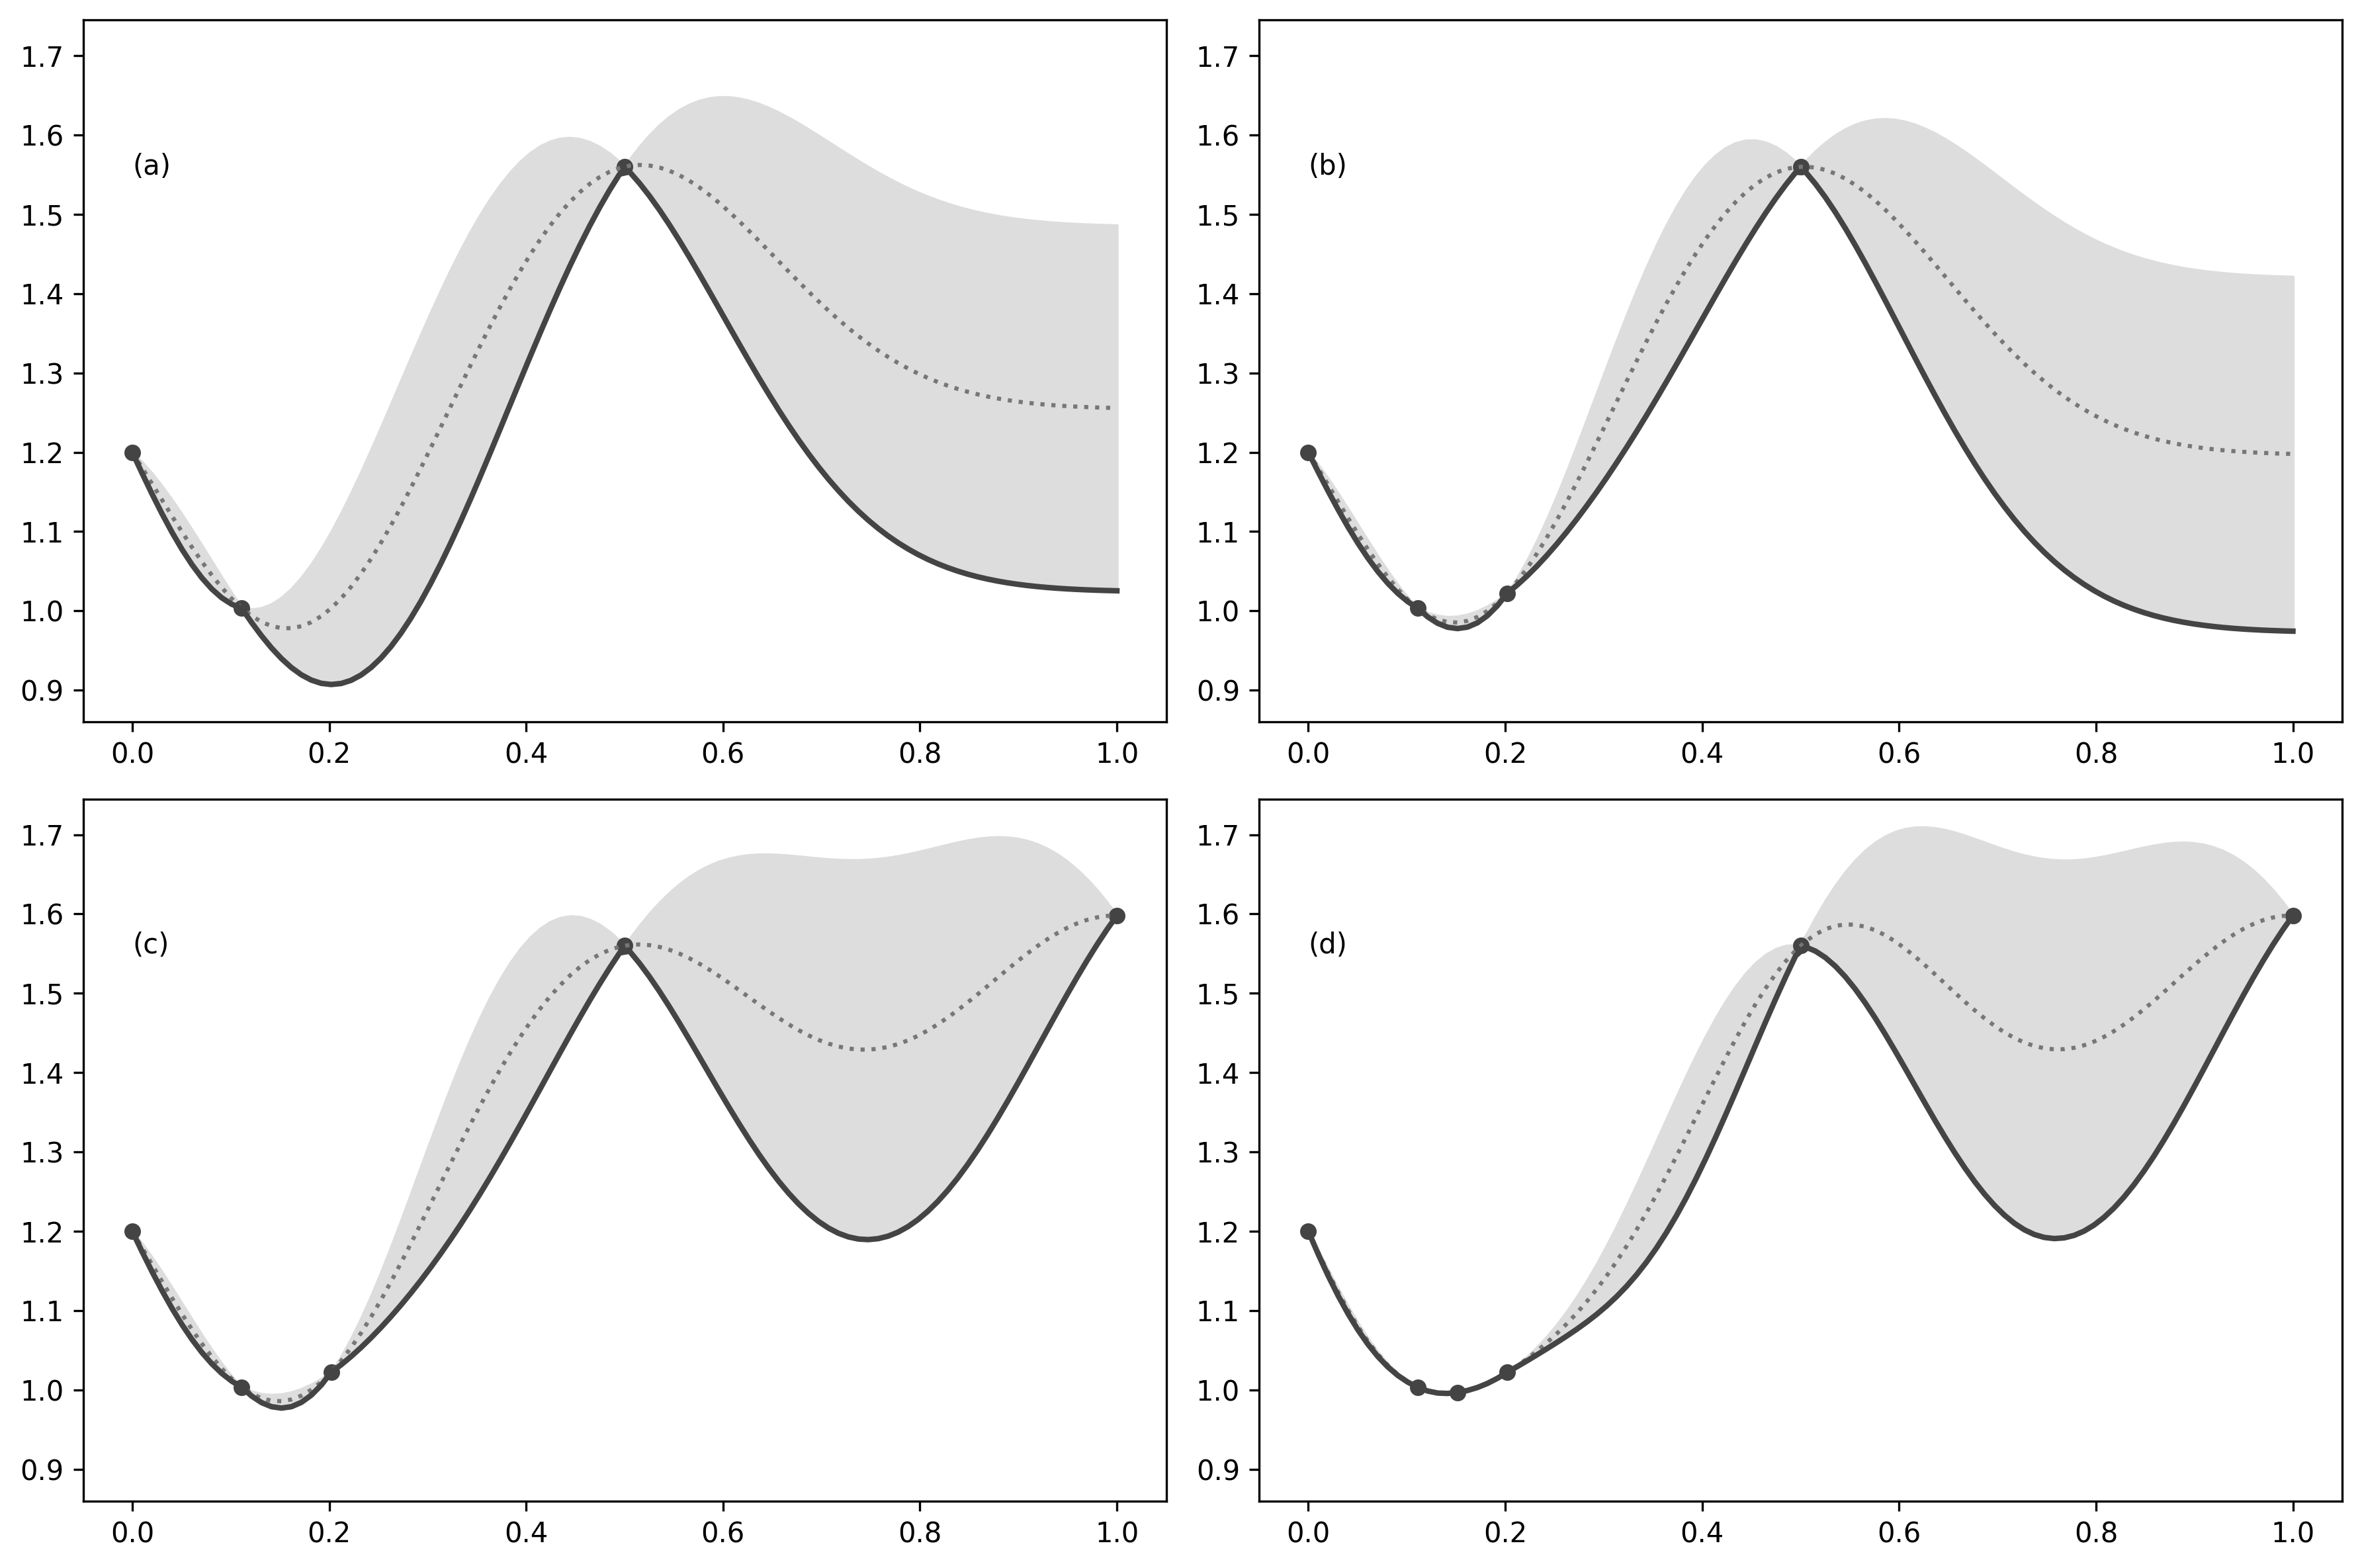

In [27]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))

plot_example_gpr(
    GPR_viz,
    ax11,
    parameters[:3],
    measurements[:3],
    err_bars=True,
    bottom_trace=True
)

plot_example_gpr(
    GPR_viz,
    ax12,
    parameters[:4],
    measurements[:4],
    err_bars=True,
    bottom_trace=True
)

plot_example_gpr(
    GPR_viz,
    ax21,
    parameters[:5],
    measurements[:5],
    err_bars=True,
    bottom_trace=True
)

plot_example_gpr(
    GPR_viz,
    ax22,
    parameters[:6],
    measurements[:6],
    err_bars=True,
    bottom_trace=True
)

c = list(ax22.axis())
c[2] -= .1
ax11.axis(c)
ax12.axis(c)
ax21.axis(c)
ax22.axis(c)

ax11.text(0, 1.55, '(a)')
ax12.text(0, 1.55, '(b)')
ax21.text(0, 1.55, '(c)')
ax22.text(0, 1.55, '(d)')

plt.tight_layout()
plt.show()


### Model the response surface with Gaussian process regression

In [28]:
(1.54 + 1.21)/2

1.375

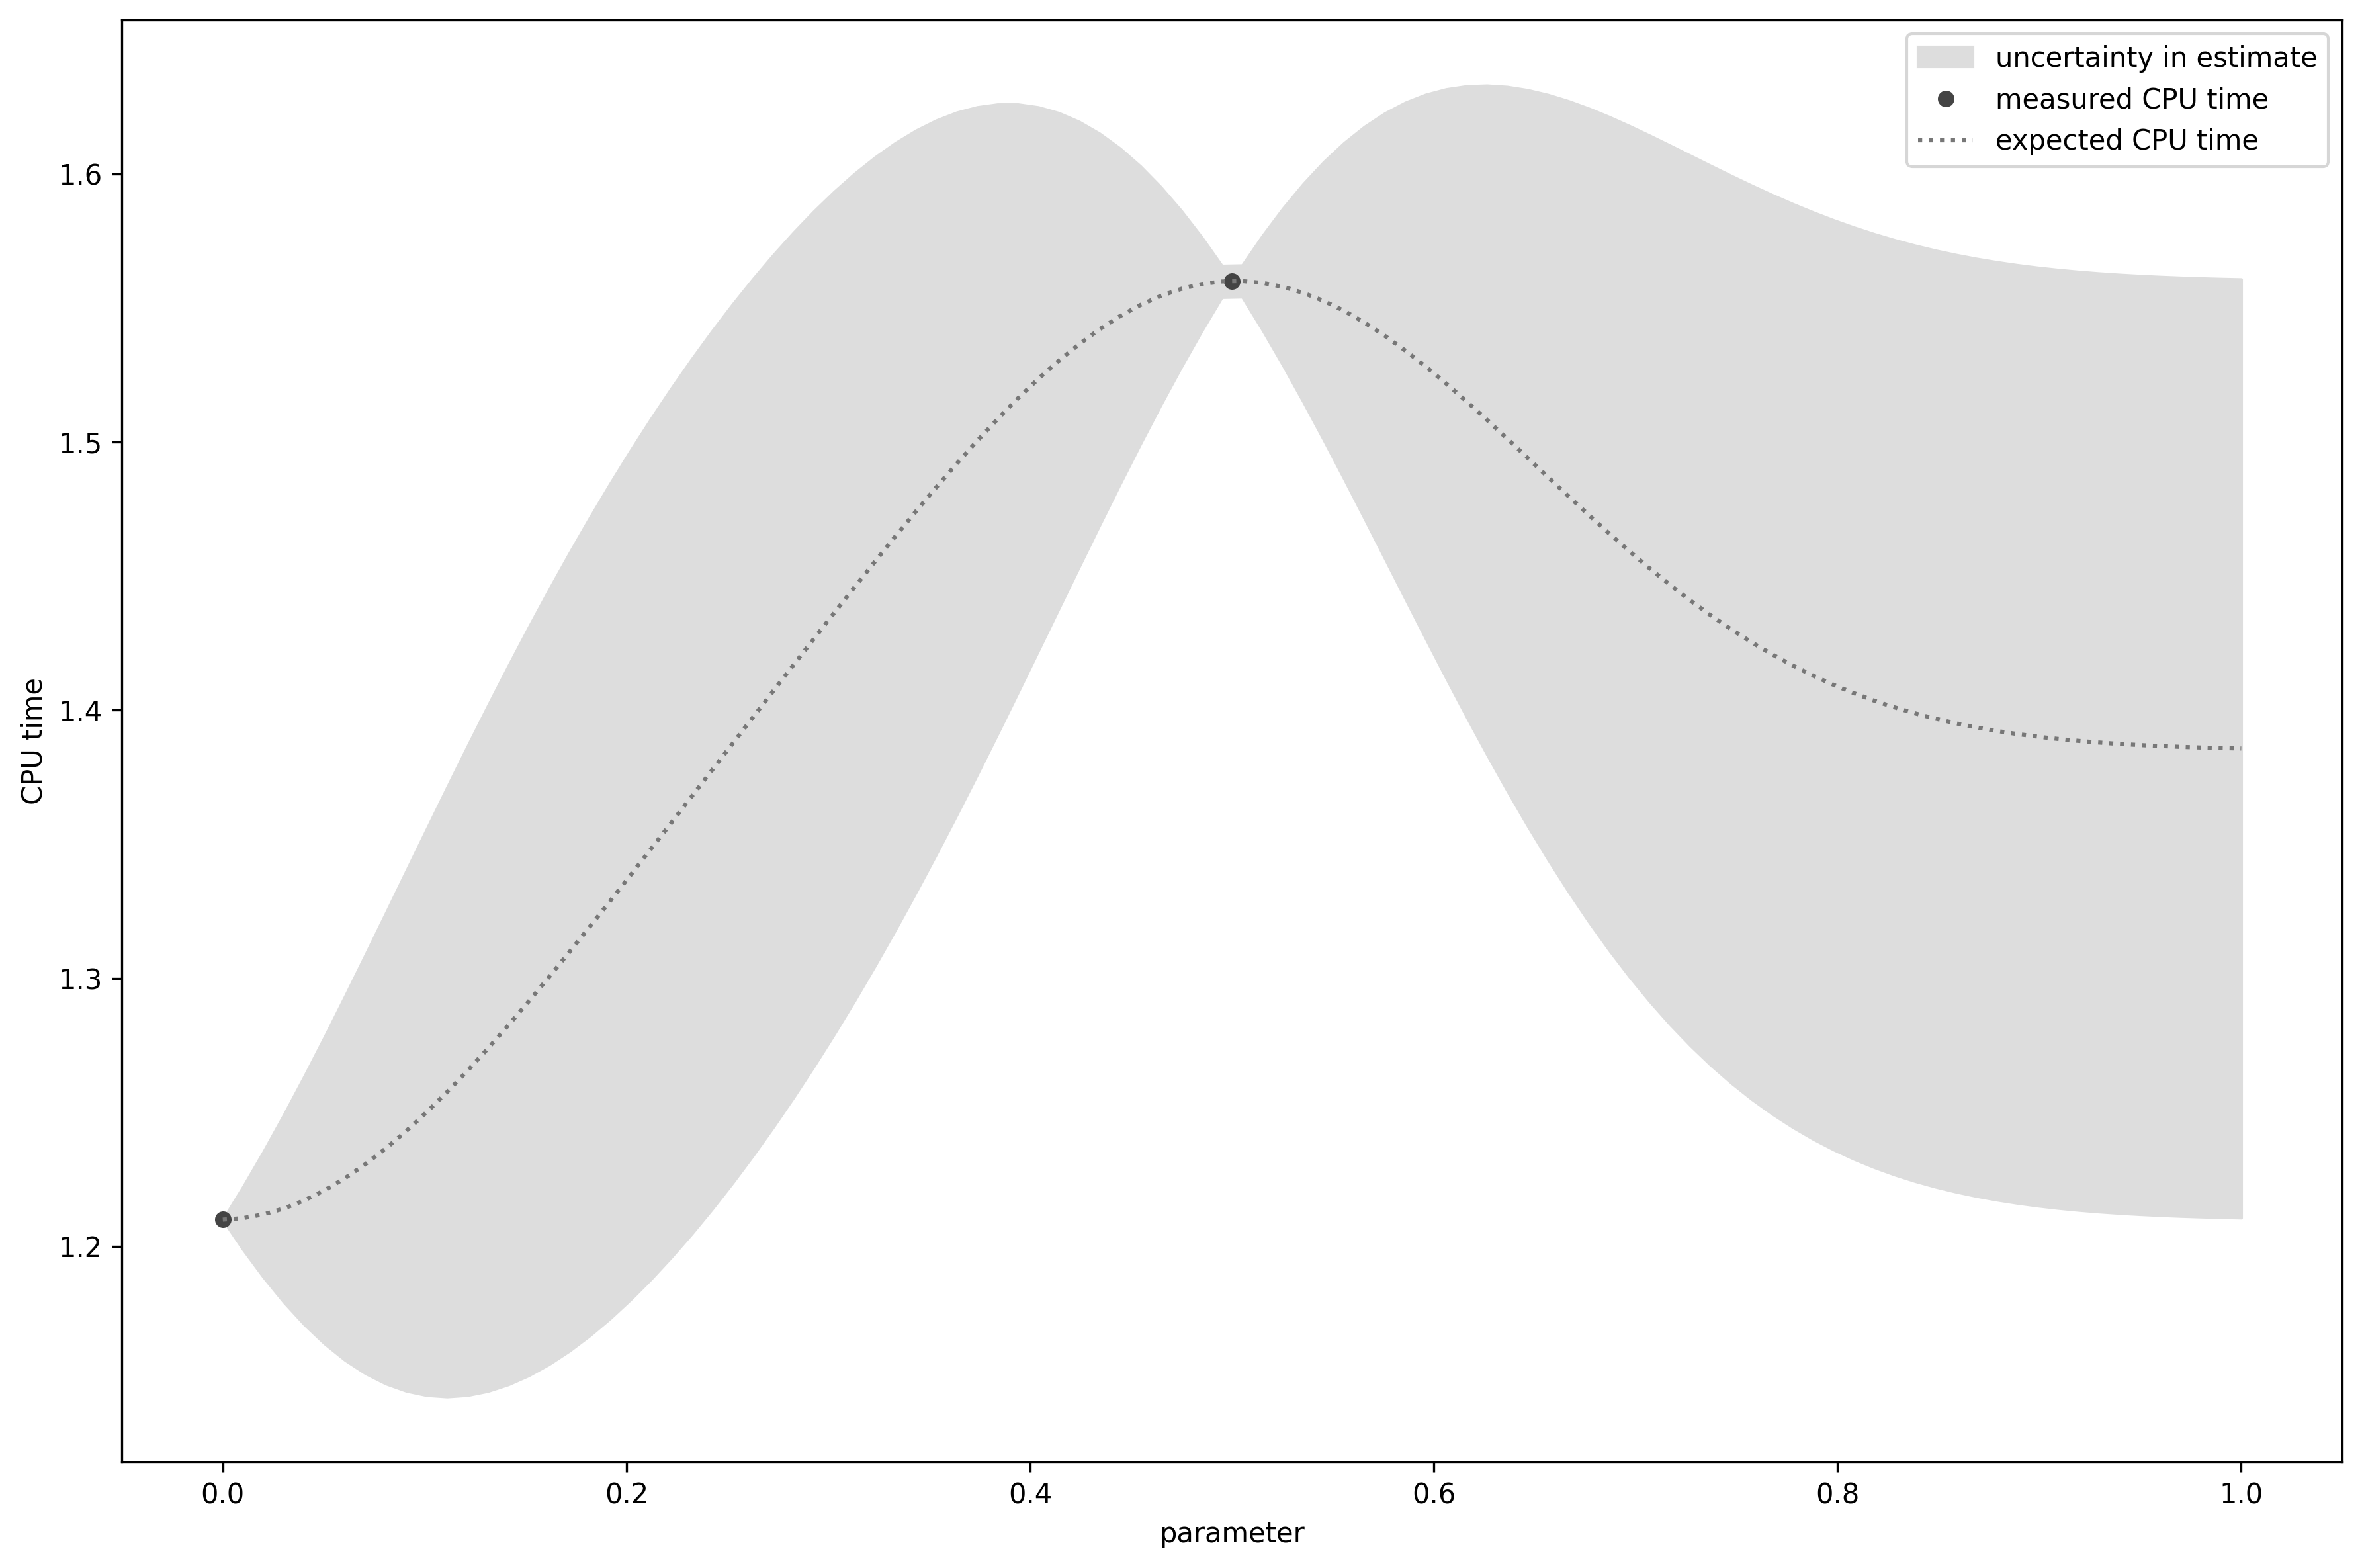

In [29]:
plt.figure(figsize=(12,8))
ax = plt.gca()
plot_example_gpr(
    GPR_viz,
    ax,
    [.5, 0],
    [1.56, 1.21],
    err_bars=True
)
plt.xlabel('parameter')
plt.ylabel('CPU time')
plt.legend(['uncertainty in estimate', 'measured CPU time', 'expected CPU time'])
plt.tight_layout()
plt.show()

In [30]:
0.8*1.56 + 0.2*1.21  # estimate for parameter=0.4 based on weighted proximity to measured parameters

1.4900000000000002

In [31]:
# Take an average of all measurements
class GPR1:
    def __init__(self, parameters, measurements):
        self.x = parameters                         # parameters input as attribute
        self.y = np.array(measurements)             # measurements input as attribute
        self.mean_y = self.y.mean()                 # simple estimate of measurement, the mean 
    
    def estimate(self, query_parameter):
        return self.mean_y                          # return estimate for query parameter

In [32]:
# Estimation based on on the average of measurements
parameters = [0.50, 0.0]
measurements = [1.52, 1.21]
gpr1 = GPR1(parameters, measurements)
print(gpr1.estimate(0.25))
print(gpr1.estimate(0.4))

1.365
1.365


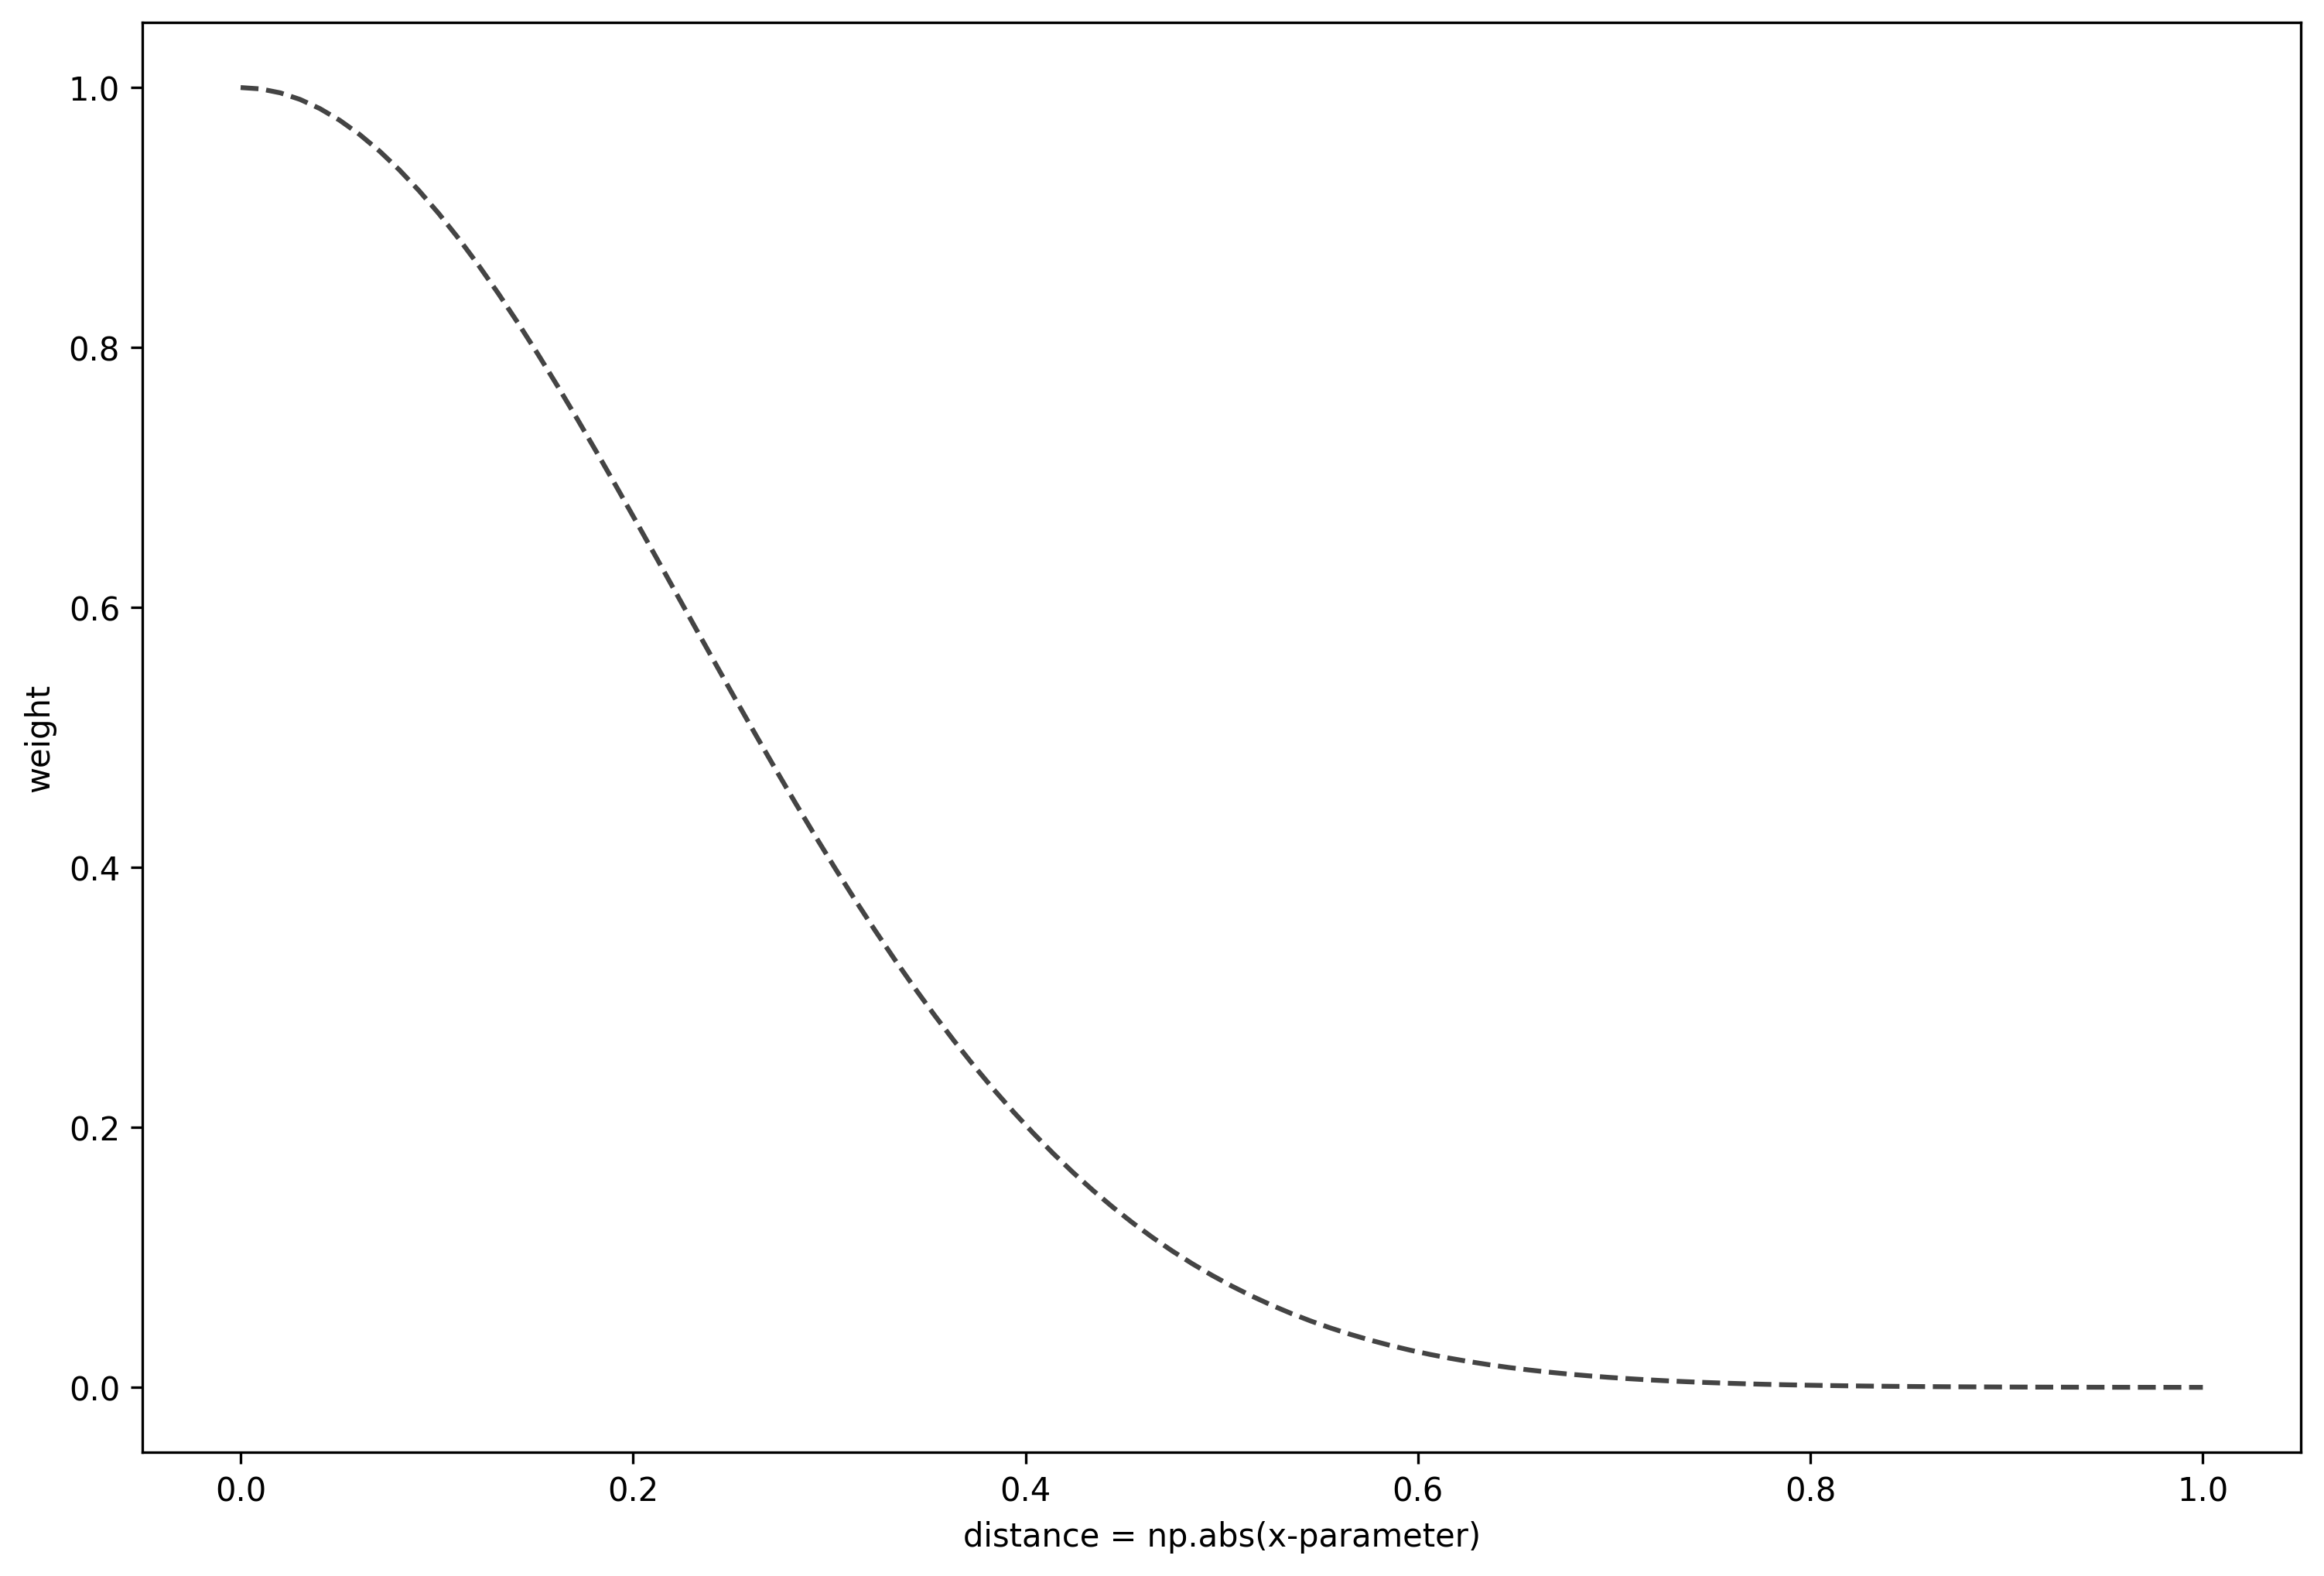

In [33]:
# Weight nearer measurements more
d = np.linspace(0, 1, 100)                  # relative distance
w = np.exp(-d**2/.1)                        # sigma = .1
plt.figure(figsize=(12,8))
plt.plot(d, w, '--', color=e4e.color_1)
plt.xlabel('distance = np.abs(x-parameter)')
plt.ylabel('weight')
plt.show()

In [34]:
# GPR with weighted average
class GPR2:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters 
        self.y = np.array(measurements)
        self.sigma = sigma 

        self.mean_y = self.y.mean()
        self.y -= self.mean_y                                   # remove average model residuals 

    def kernel(self, x1, x2):                                   # squared exponential kernel function
        distance_squared = ((x1-x2)**2).sum()                   # np.int64.sum? scalar version of array func
        return np.exp(-distance_squared / (2*self.sigma**2)) 
    
    def estimate(self, query_parameter):
        weights = [
            self.kernel(x, query_parameter)
            for x in self.x
        ]                                                       # one weight for each residual
        weights = np.array(weights)                             
        weights = weights / weights.sum()                       # weights must sum to 1
        return self.mean_y + weights @ self.y                   # combine mean and weighted residuals

In [35]:
# Estimates based on distance weighted average from measurements
parameters = np.array([0.50, 0.0])
measurements = [1.52, 1.21]
gpr2 = GPR2(parameters, measurements, sigma=0.25)
print(gpr2.estimate(0.25))
print(gpr2.estimate(0.4))

1.365
1.4482426828846955


#### Don't overweight clustered measurements

1.3989447654272769 1.365


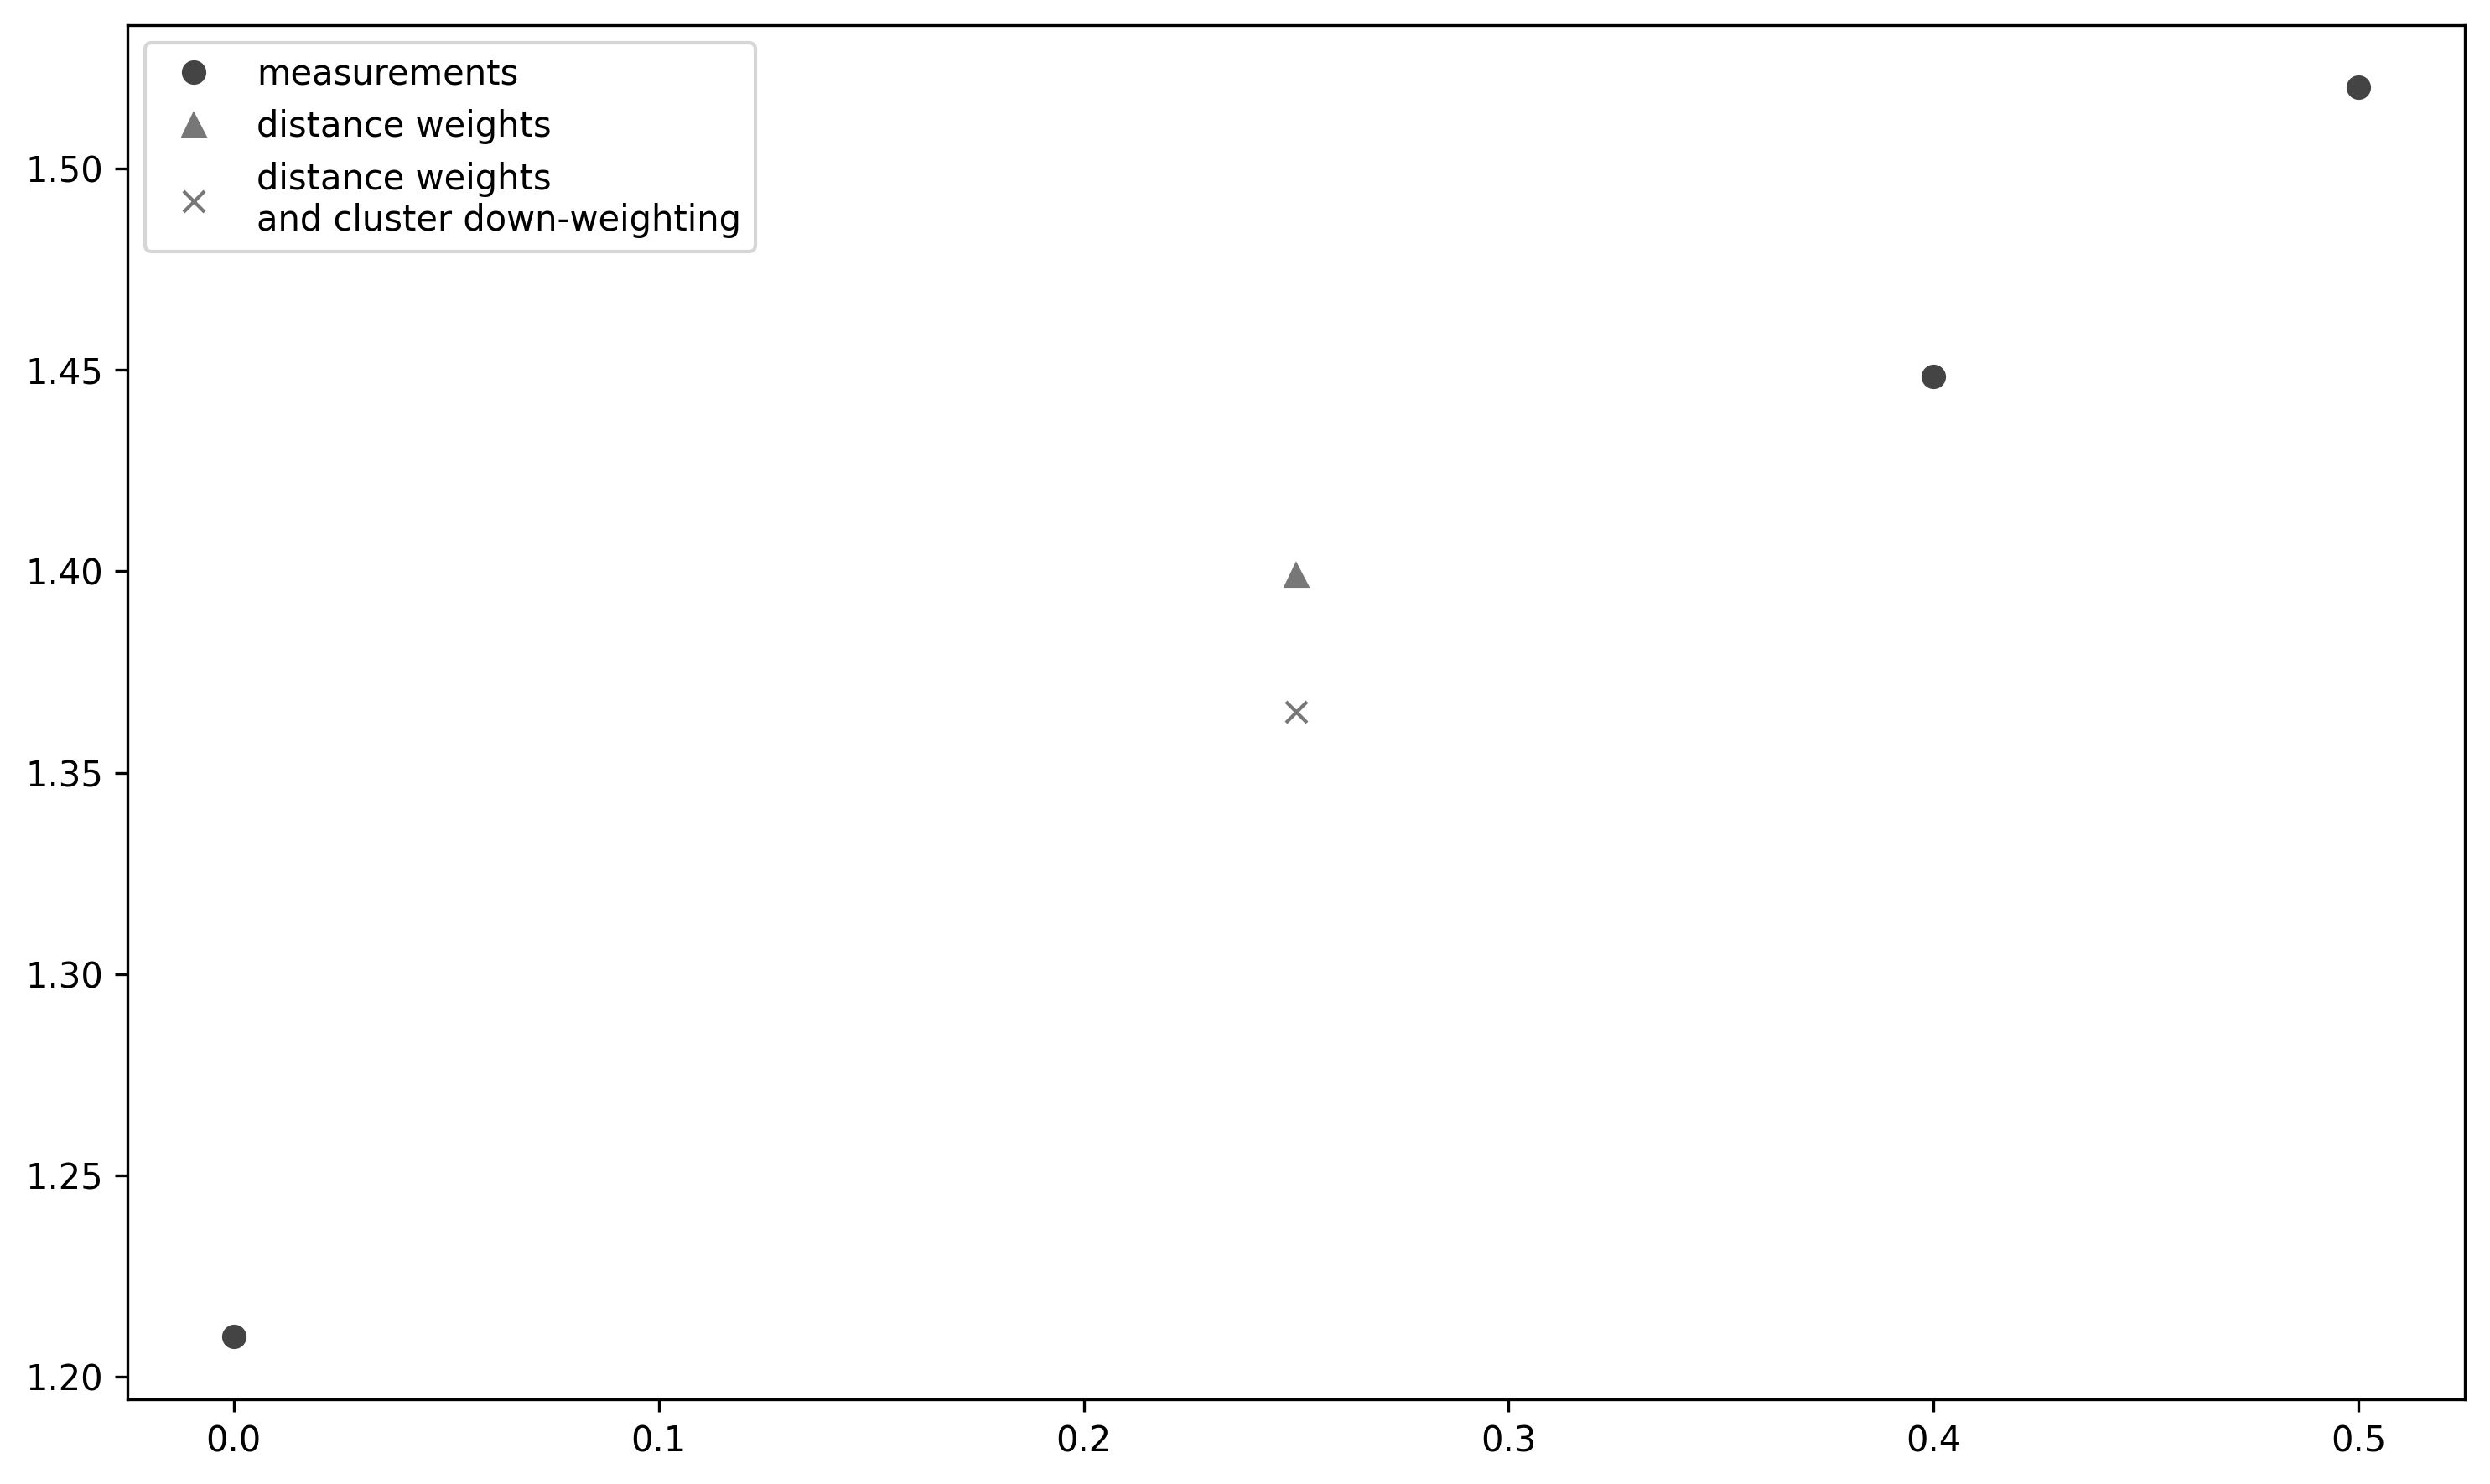

In [36]:
parameters = np.array([0.5, 0.0, 0.4])
measurements = [1.52, 1.21, gpr2.estimate(0.4)]
gpr2a = GPR2(parameters, measurements, sigma=0.25)
print(gpr2a.estimate(0.25), gpr1.estimate(0.25) )
plt.figure(figsize=(10,6))
plt.plot(parameters, measurements, 'o', color=e4e.color_1)
plt.plot([0.25], [gpr2a.estimate(0.25)], '^', color=e4e.color_2)
plt.plot([0.25], [gpr2.estimate(0.25)], 'x', color=e4e.color_2)

plt.legend(['measurements', 
            'distance weights', 
            'distance weights\nand cluster down-weighting',
           ])
plt.tight_layout()
plt.show()

In [37]:
# Full Gaussian process regression
class GPR3:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters 
        self.y = np.array(measurements)
        self.sigma = sigma 

        self.mean_y = self.y.mean()
        self.y -= self.mean_y                       # model residuals around naive estimate (mean)
    
    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2)**2).sum()
        return np.exp(-distance_squared/(2*self.sigma**2))
    
    def estimate(self, query_parameter):            # kernel_x_query is a vector
        kernels_x_query = np.array([                
            self.kernel(x, query_parameter)
            for x in self.x
        ])  # ensure query_parameter estimate close to measurements of near parameter values                   

        kernels_x_x = np.array([                    # kernel_x_x is a matrix
            [
                self.kernel(x1, x2)
                for x1 in self.x
            ]
            for x2 in self.x
        ])  # for downweighting clusted parameters (which have higher kernel values ie ~ 1)           

        # weights increases with kernels_x_query and decrease with kernels_x_x
        weights = kernels_x_query.T @ np.linalg.inv(kernels_x_x)    # inv (denominator) to lower cluster weights
        return self.mean_y + weights @ self.y

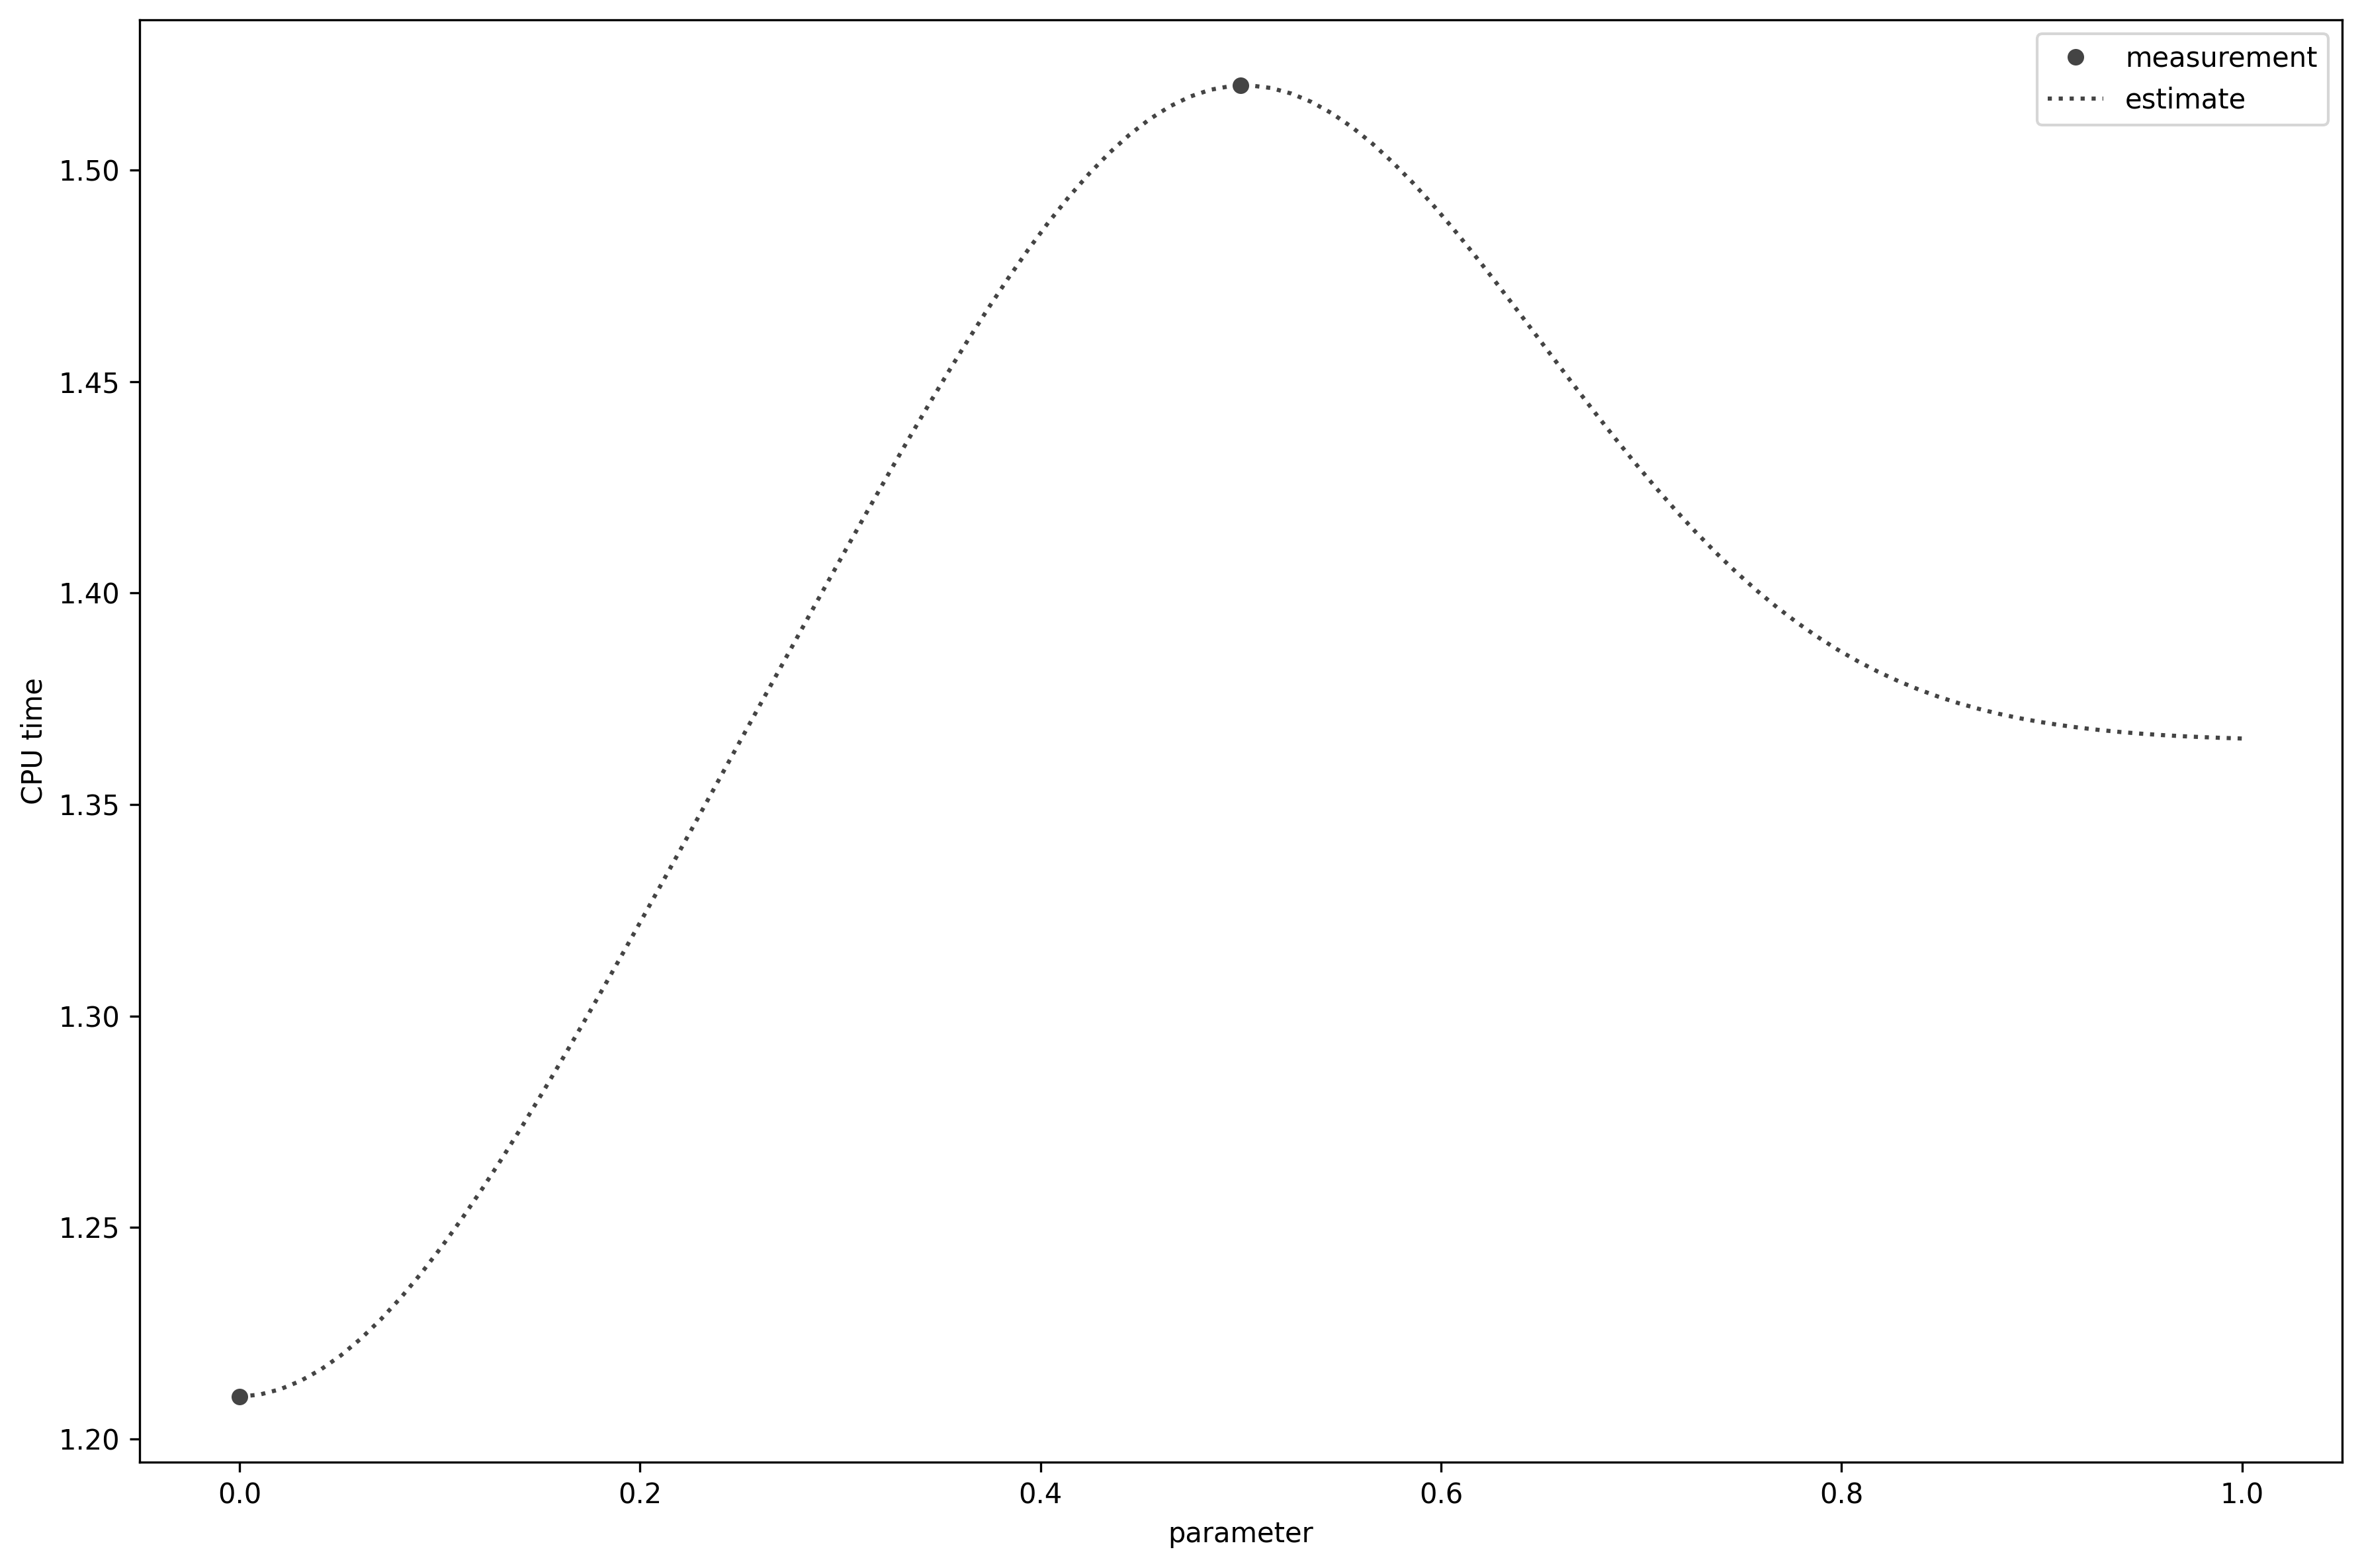

In [38]:
parameters = np.array([0.5, 0.0])
measurements = [1.52, 1.21]
gpr3 = GPR3(parameters, measurements, sigma=0.15)
x_hats = np.linspace(0, 1, 100)
y_hats = [gpr3.estimate(x_hat) for x_hat in x_hats]

plt.figure(figsize=(12,8))
plt.plot(parameters, measurements, 'o', color=e4e.color_1, markersize=5) 
plt.plot(x_hats, y_hats, ':', color=e4e.color_1)
plt.xlabel('parameter')
plt.ylabel('CPU time')
plt.legend(['measurement', 'estimate'])
plt.tight_layout()
plt.show()

In [39]:
def plot_gpr_ex(GPR, err_bars):
    fig, ax = plt.subplots(2,2, figsize=(12,8))

    np.random.seed(18)
    x = np.random.uniform(size=(3,))
    y = 1 - (x-0.4)**2
    plot_example_gpr(GPR, ax[0][0], x, y, err_bars)

    x = np.random.uniform(size=(4,))
    y = (x-0.7)**2 + 2*x**3
    plot_example_gpr(GPR, ax[0][1], x, y, err_bars)

    x = np.random.uniform(size=(4,))
    y = 1 - (x-0.3)**2 + .25*np.sin(10*x)
    plot_example_gpr(GPR, ax[1][0], x, y, err_bars)

    x = np.random.uniform(size=(5,))
    y = 1 - (x-0.9)**2 + .1*np.sin(10*(x-0.2))
    plot_example_gpr(GPR, ax[1][1], x, y, err_bars)

    ax[1][1].legend(['measurements', 'GPR estimate'], loc='lower right')
    ax[1][0].set_xlabel('parameter')
    ax[1][1].set_xlabel('parameter')
    ax[1][0].set_xlabel('business metric')
    ax[1][1].set_xlabel('business metric')

    plt.tight_layout()
    plt.show()

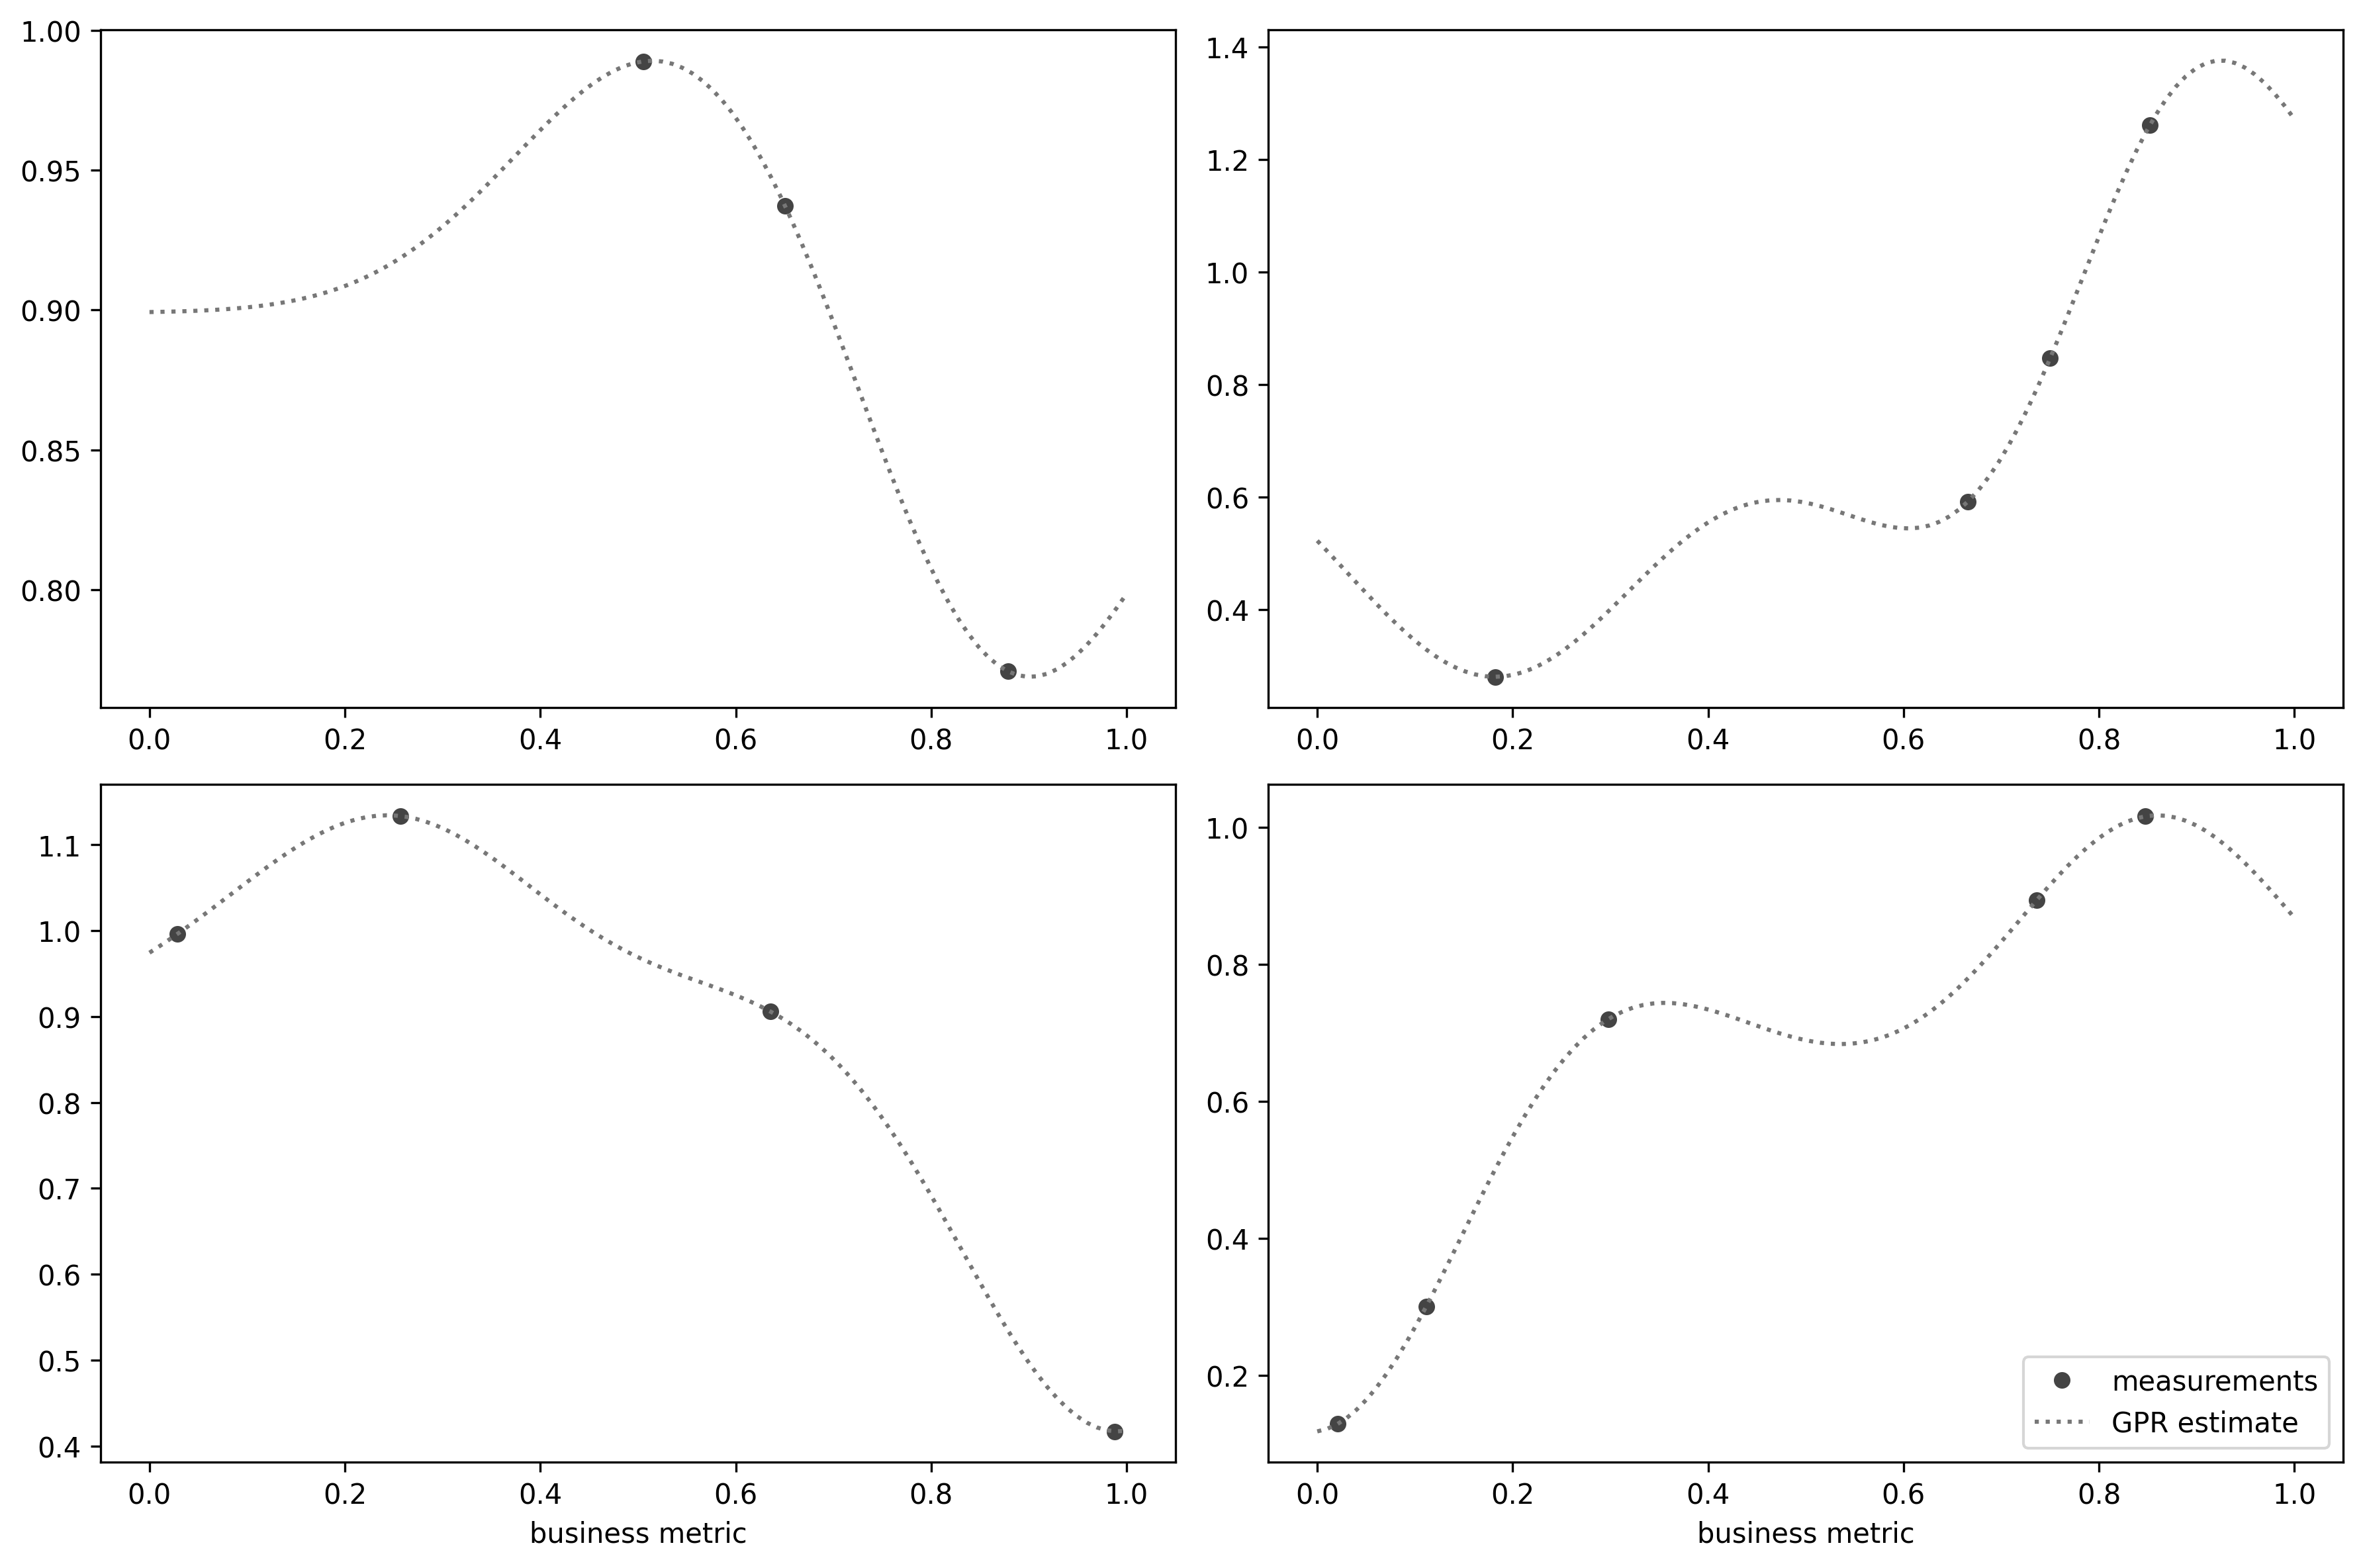

In [40]:
plot_gpr_ex(GPR3, err_bars=False)

### Estimate uncertainty with GPR

weights = kernels_x_query.T @ np.linalg.inv(kernels_x_x)

certainty_squared = weights @ kernels_x_query    -- squared exponetial kernel to model certainty (ie certainty is 1 at 0 distance from measurement and 0 at a far distance from measurement. We also weight this certainty with the same distance considerations as the estimates ie closeness increases weight, clusters decrease weight)

uncertainty_squared = 1 - certainty_squared 


In [41]:
# Complete Gaussian process regression
class GPR4:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma 

        self.mean_y = self.y.mean()
        if len(self.y) > 1:                 # Need at least two y's to compute standard deviation
            self.std_y = self.y.std()
        else:
            self.std_y = 1
        
        self.y -= self.mean_y
    
    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2)**2).sum()
        return np.exp(-distance_squared / (2* self.sigma**2))
    
    def estimate(self, query_parameter):
        kernels_x_query = np.array([
            self.kernel(x, query_parameter)
            for x in self.x
        ])
        kernels_x_x = np.array([
            [
                self.kernel(x1, x2)
                for x1 in self.x
            ]
            for x2 in self.x
        ])

        weights = kernels_x_query.T @ np.linalg.pinv(kernels_x_x)
        expectation = self.mean_y + weights@self.y      

        # model estimate certainty squared with squared exponential function (1 at measurement, 0 far away)
        # estimate certainty squared also subject to same distance relevance weighting as estimate itself
        # convert certainty squared to uncertainty squared (0 at measurement, 1 far away)
        # convert uncertainty squared to uncertainty before scaling with std to match measurement
        # uncertainty in GPR estimate is different from aggregated measurement uncertainty (standard error)
        # uncertainty in GPR estimate is a relative measure of uncertainty hence distance weighting
        uncertainty_squared = 1 - weights@ kernels_x_query      # relevance-weighted squared uncertainty
        uncertainty = np.sqrt(uncertainty_squared)              # want uncertainty not squared uncertainty
        return expectation, self.std_y*uncertainty              # scale uncertainty to match measurements

In [42]:
parameters = np.array([0.5, 0.0])
measurements = [1.52, 1.21]
gpr4 = GPR4(parameters, measurements, sigma=.15)
x_hats = np.linspace(0, 1, 100)
y_hats, sigma_y_hats = zip(*[gpr4.estimate(x_hat)for x_hat  # tuples are packed into a list. The tuples are
                             in x_hats]) # unpacked into zip() function which zips all ith-elements of tuples

/var/folders/35/13t91srs6wg9ml5d___c_nh40000gn/T/ipykernel_858/3108910800.py:16: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x14a538e50> starts with '_'. It is thus excluded from the legend.
  ax.legend([ 'uncertainty in estimate', '_nolegend_', 'expected CPU time'])


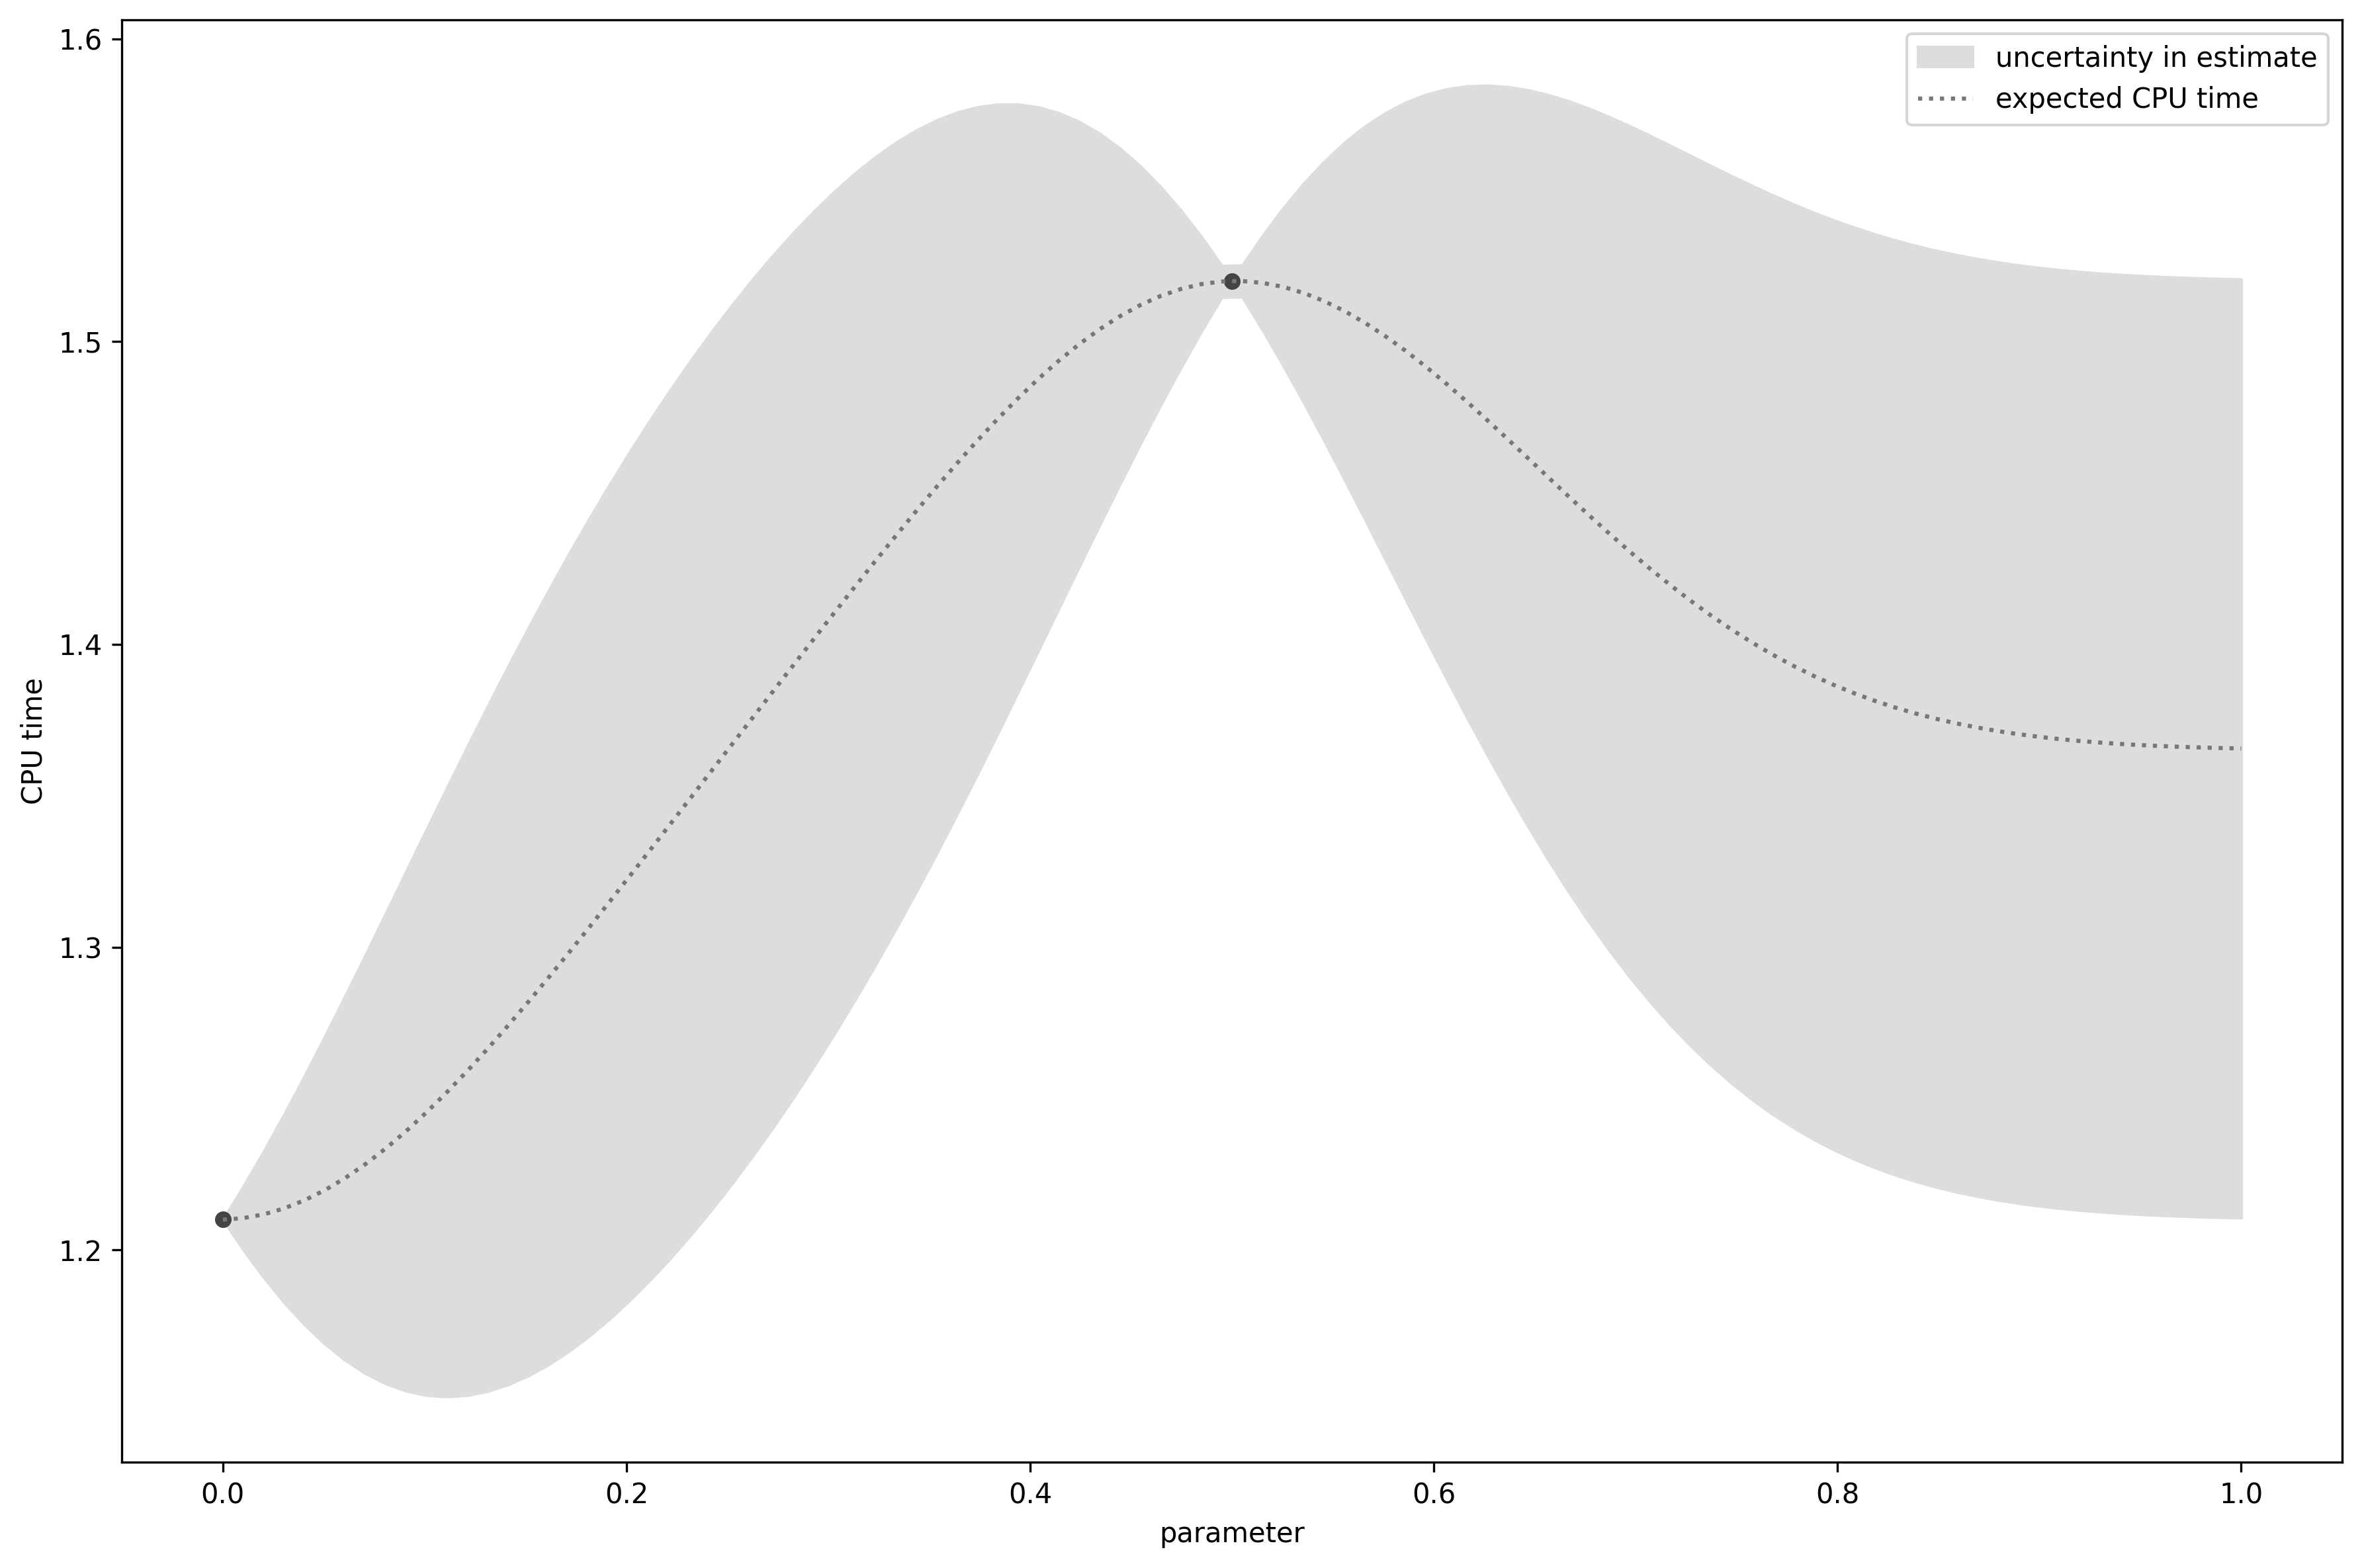

In [43]:
parameters = np.array([0.5, 0.0])
measurements = [1.52, 1.21]

plt.figure(figsize=(12,8))
ax = plt.gca()
plot_example_gpr(
    GPR4,
    ax,
    parameters,
    measurements,
    err_bars=True
)

ax.set_xlabel('parameter')
ax.set_ylabel('CPU time')
ax.legend([ 'uncertainty in estimate', '_nolegend_', 'expected CPU time'])

plt.tight_layout()
plt.show()

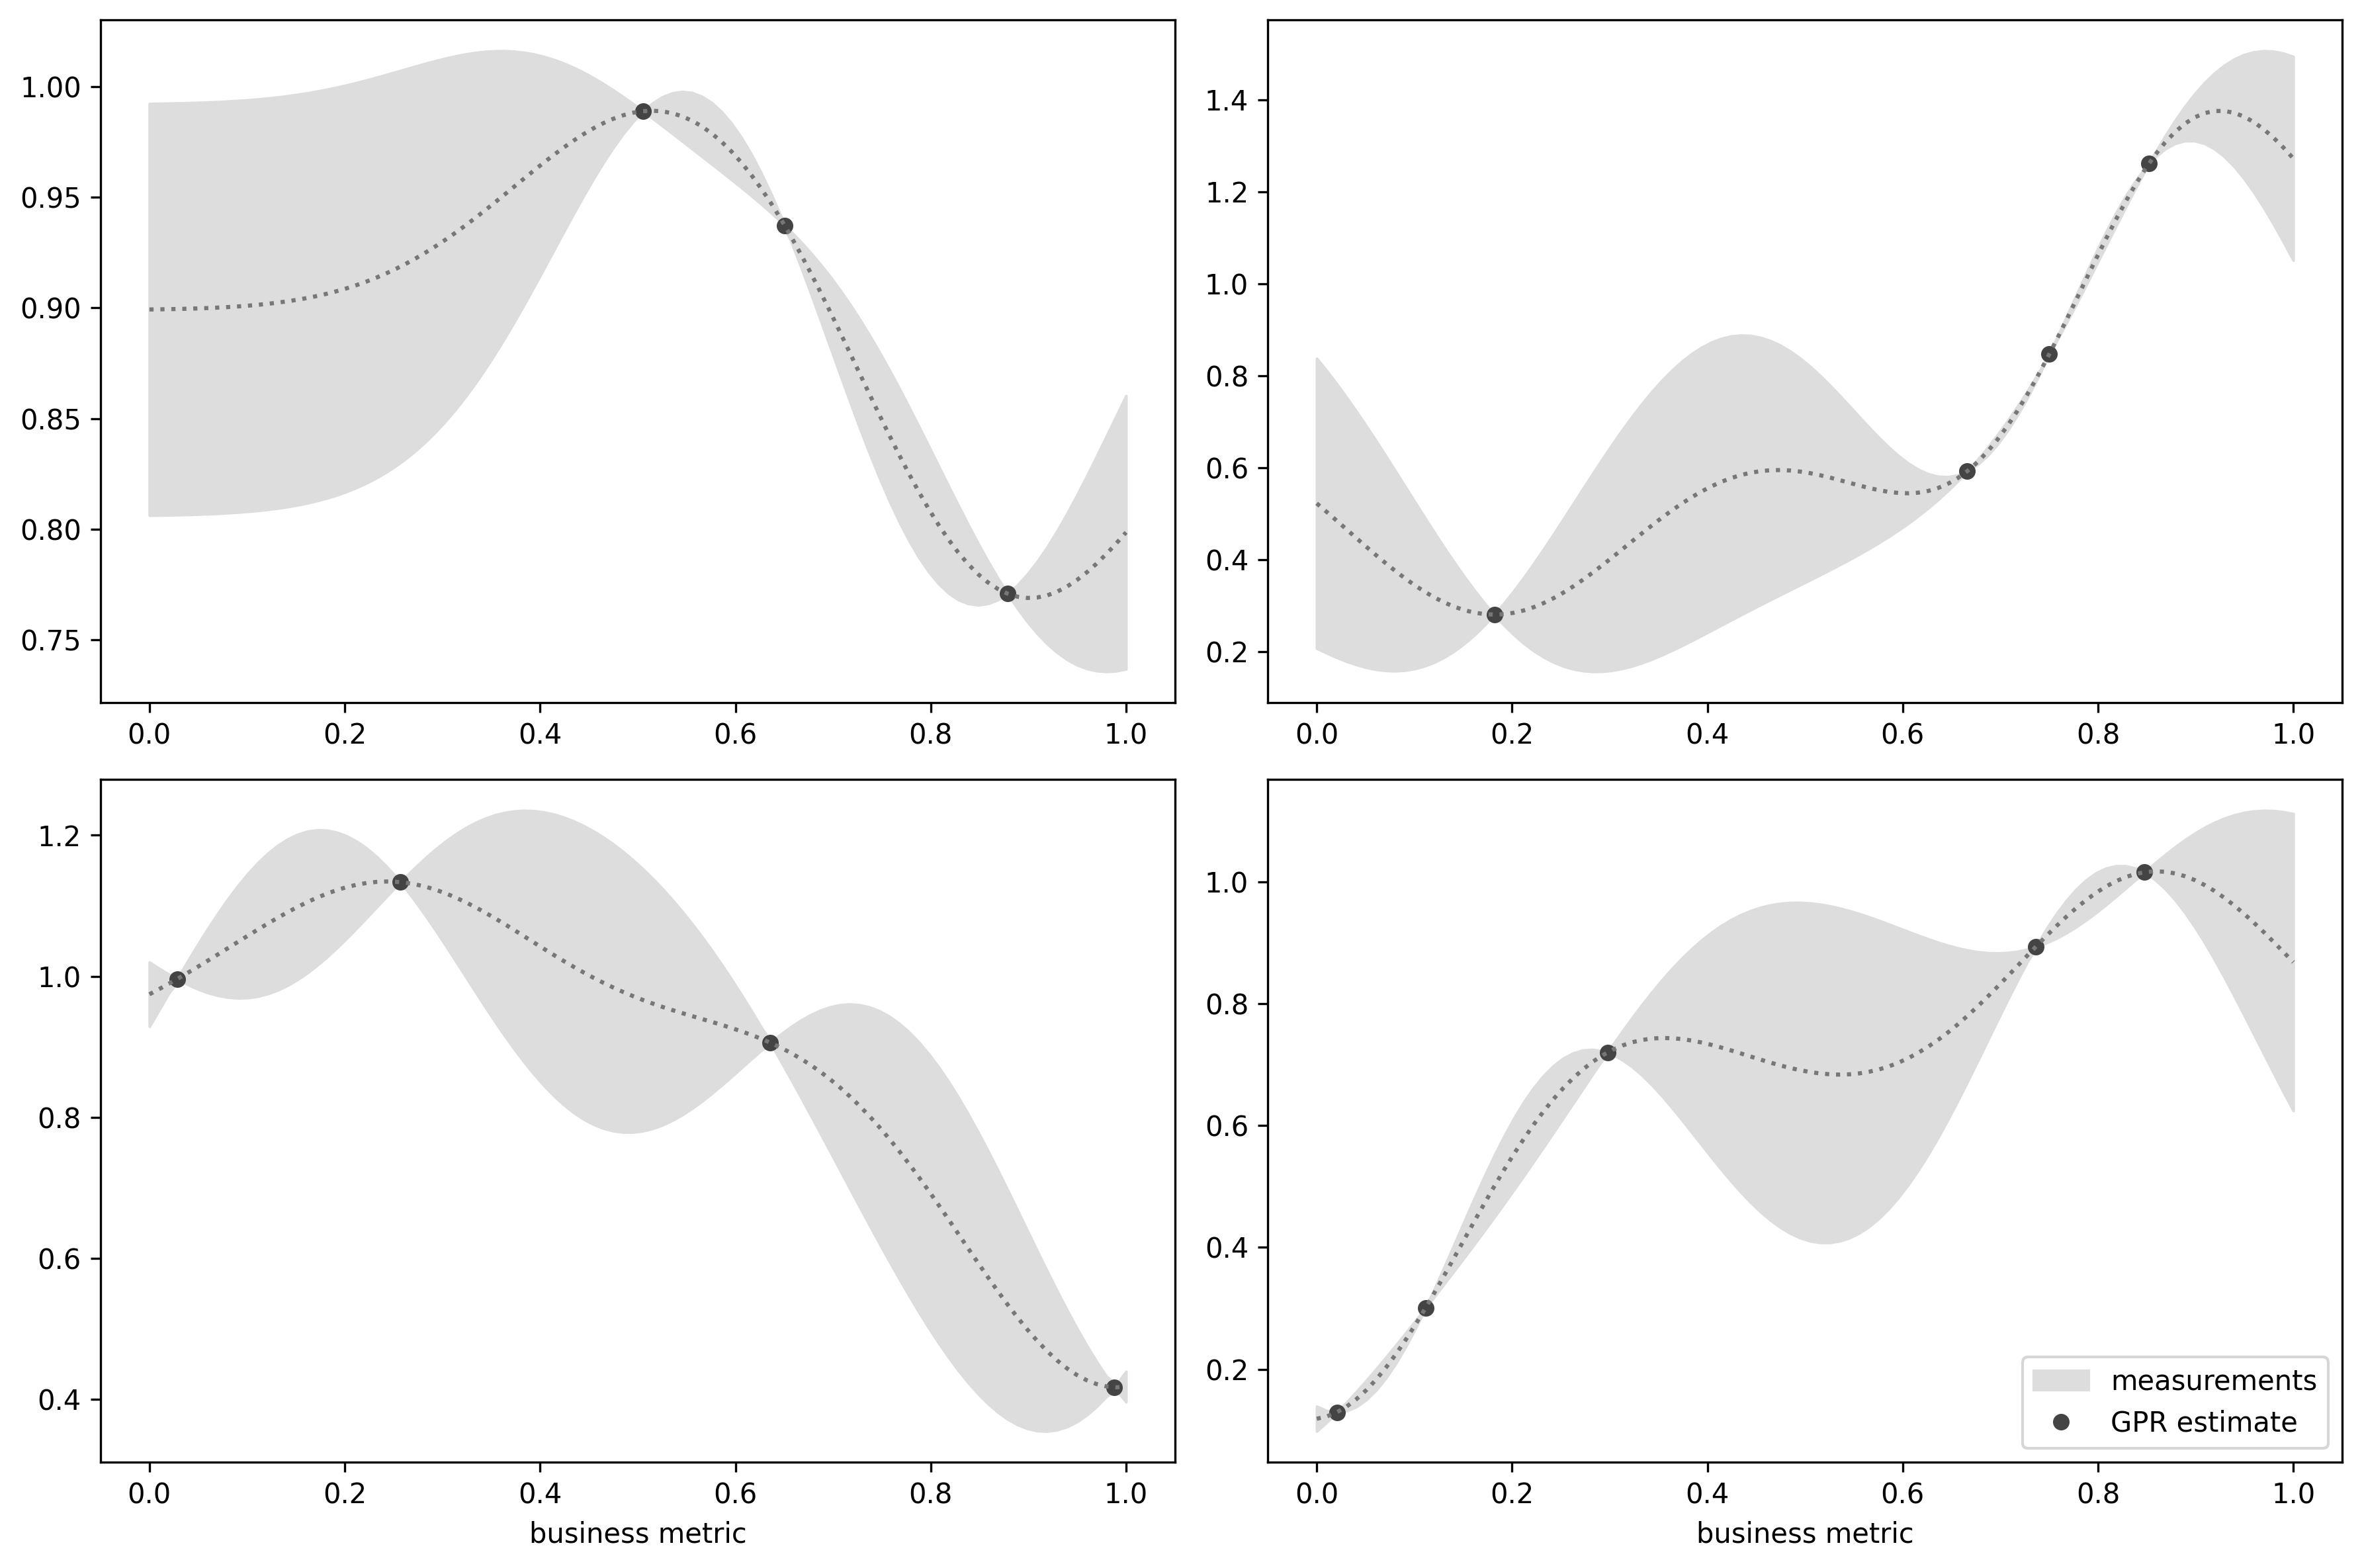

In [44]:
plot_gpr_ex(GPR4, err_bars=True)

### Optimize over an acquisition function

Text(0.4, 1.2, 'Design of next experiment\nChoose lowest point of grey area which is \nminimal of expectation (exploitation)\nminus uncertainty (exploration)\n')

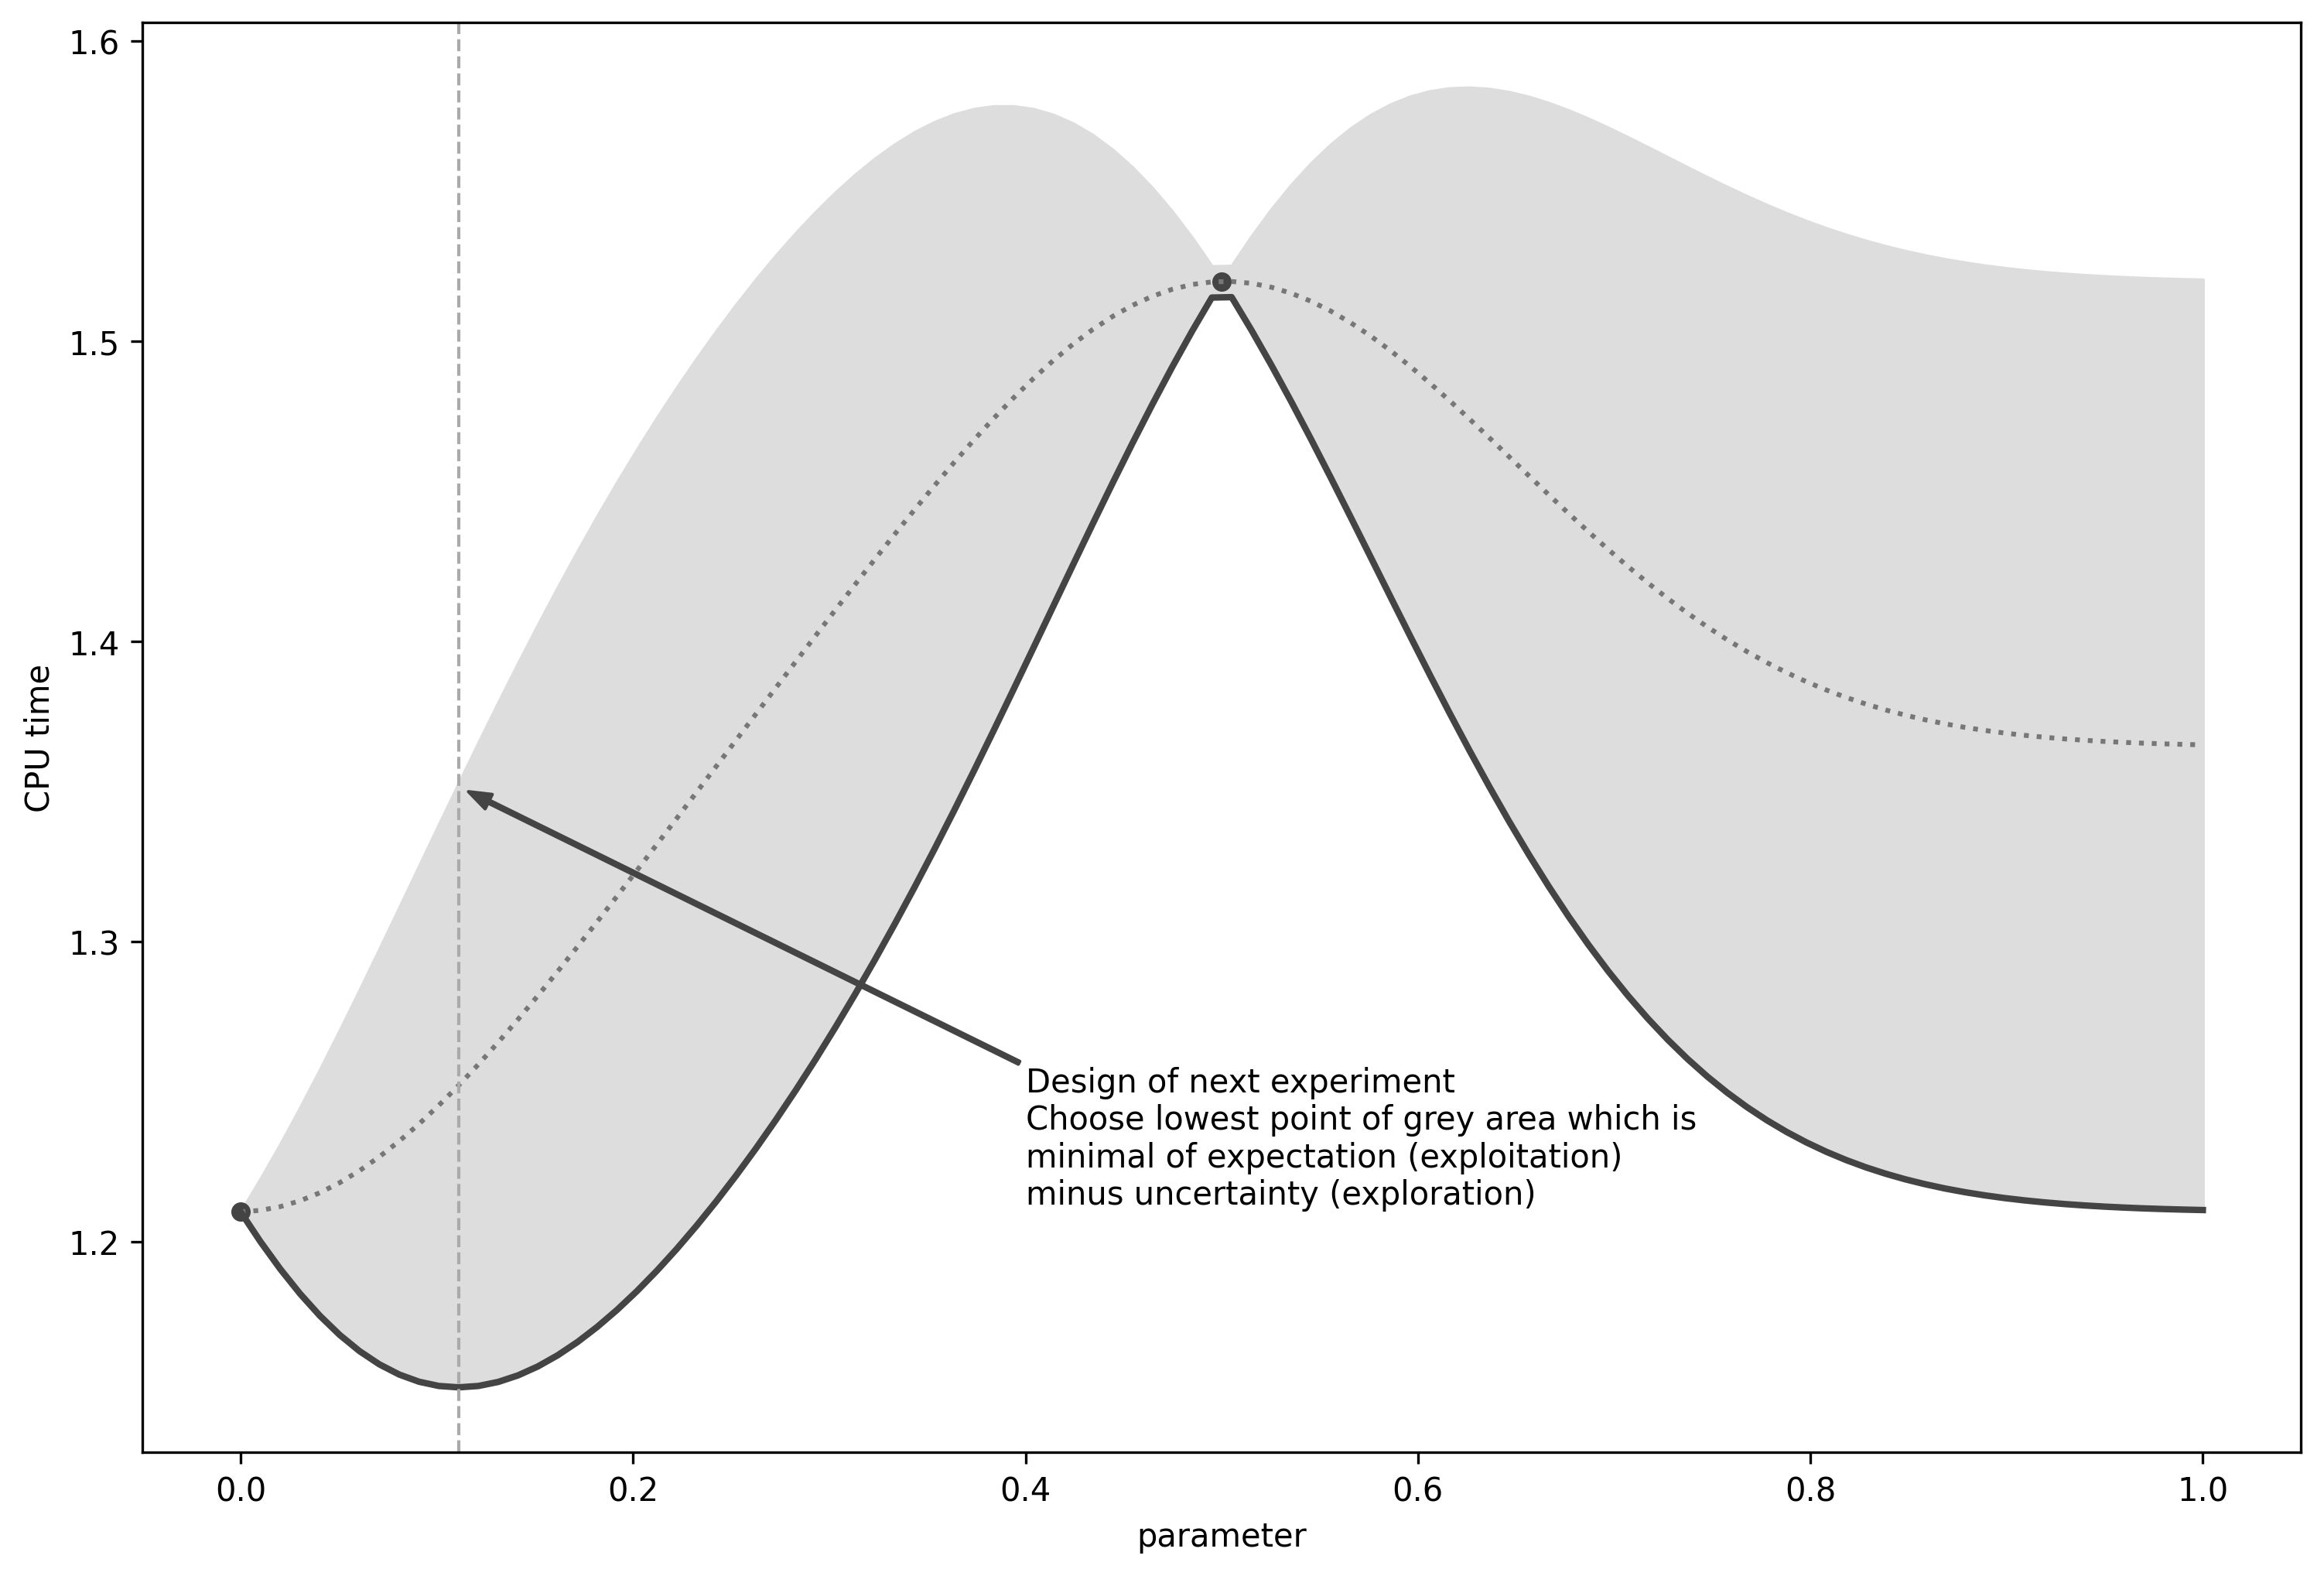

In [45]:
parameters = [0.5, 0.0]
measurements = [1.52, 1.21]

plt.figure(figsize=(12,8))
ax = plt.gca()
plot_example_gpr(
    GPR_viz,
    ax,
    parameters,
    measurements,
    err_bars=True,
    bottom_trace=True
)

plt.xlabel('parameter')
plt.ylabel('CPU time')

e4e.vertical_line(.111111)

plt.annotate("Design of next experiment\n"
             "Choose lowest point of grey area which is \n"
             "minimal of expectation (exploitation)\n" 
             "minus uncertainty (exploration)\n"
              ,
             xy=[.111111 + 0.005, 1.35],
             xytext=[0.4,1.2],
             arrowprops=e4e.arrow_props,
             )

In [46]:
# Minimize the acquistion function
parameters = np.array([0.5, 0.0])
measurements = [1.52, 1.21]
gpr4 = GPR4(parameters, measurements, sigma=0.15)
x_hats = np.linspace(0, 1, 100)
y_hats, sigma_y_hats = zip(*[gpr4.estimate(x_hat) for x_hat in x_hats])
k = 1 
lcb = np.array(y_hats) - k*np.array(sigma_y_hats)   # acquistion function, lower confidence bound

In [48]:
i = np.where(lcb == lcb.min())
x_hats[i]

array([0.11111111])

### Optimize all seven compiler parameters

#### Random search

In [69]:
def evaluate(gpr, x):
    x = np.mod(x, 1)                    # ensure parameter vector in [0,1] (np.mod() for vectorization)
    y, sigma_y = gpr.estimate(x)       
    lcb = y - sigma_y                   # acquisition function 
    return x, lcb                        

def random_search(gpr, num_parameters, num_iterations=1000):    # optimize num_parameters parameters at a time
    step_size = 0.1                     
    x_current = np.random.normal(size=num_parameters)   # initialize current parameter vector
    x_current, lcb_current = evaluate(gpr, x_current)   # initial acquistion function values
    trace = []
    for _ in range(num_iterations):
        x_test = (
            x_current 
            + step_size*np.random.normal(size=num_parameters)
        )                                                       # generate new test vector
        x_test, lcb_test = evaluate(gpr, x_test)                
        if lcb_test < lcb_current:      # if test vector has better lcb, make it the new current vector
            lcb_current = lcb_test                  
            x_current = x_test 
        trace.append(lcb_current)
    return x_current, np.array(trace)

In [70]:
np.random.seed(17)
parameters = [np.array([0.5]), np.array([0.0])]     # two parameter_1 values
measurements = [1.52, 1.21]                         # measurements at two parameter_1 values
gpr4 = GPR4(parameters, measurements, sigma=0.15)
x_opt, trace = random_search(gpr4, num_parameters=1)
print(x_opt)

[0.11096591]


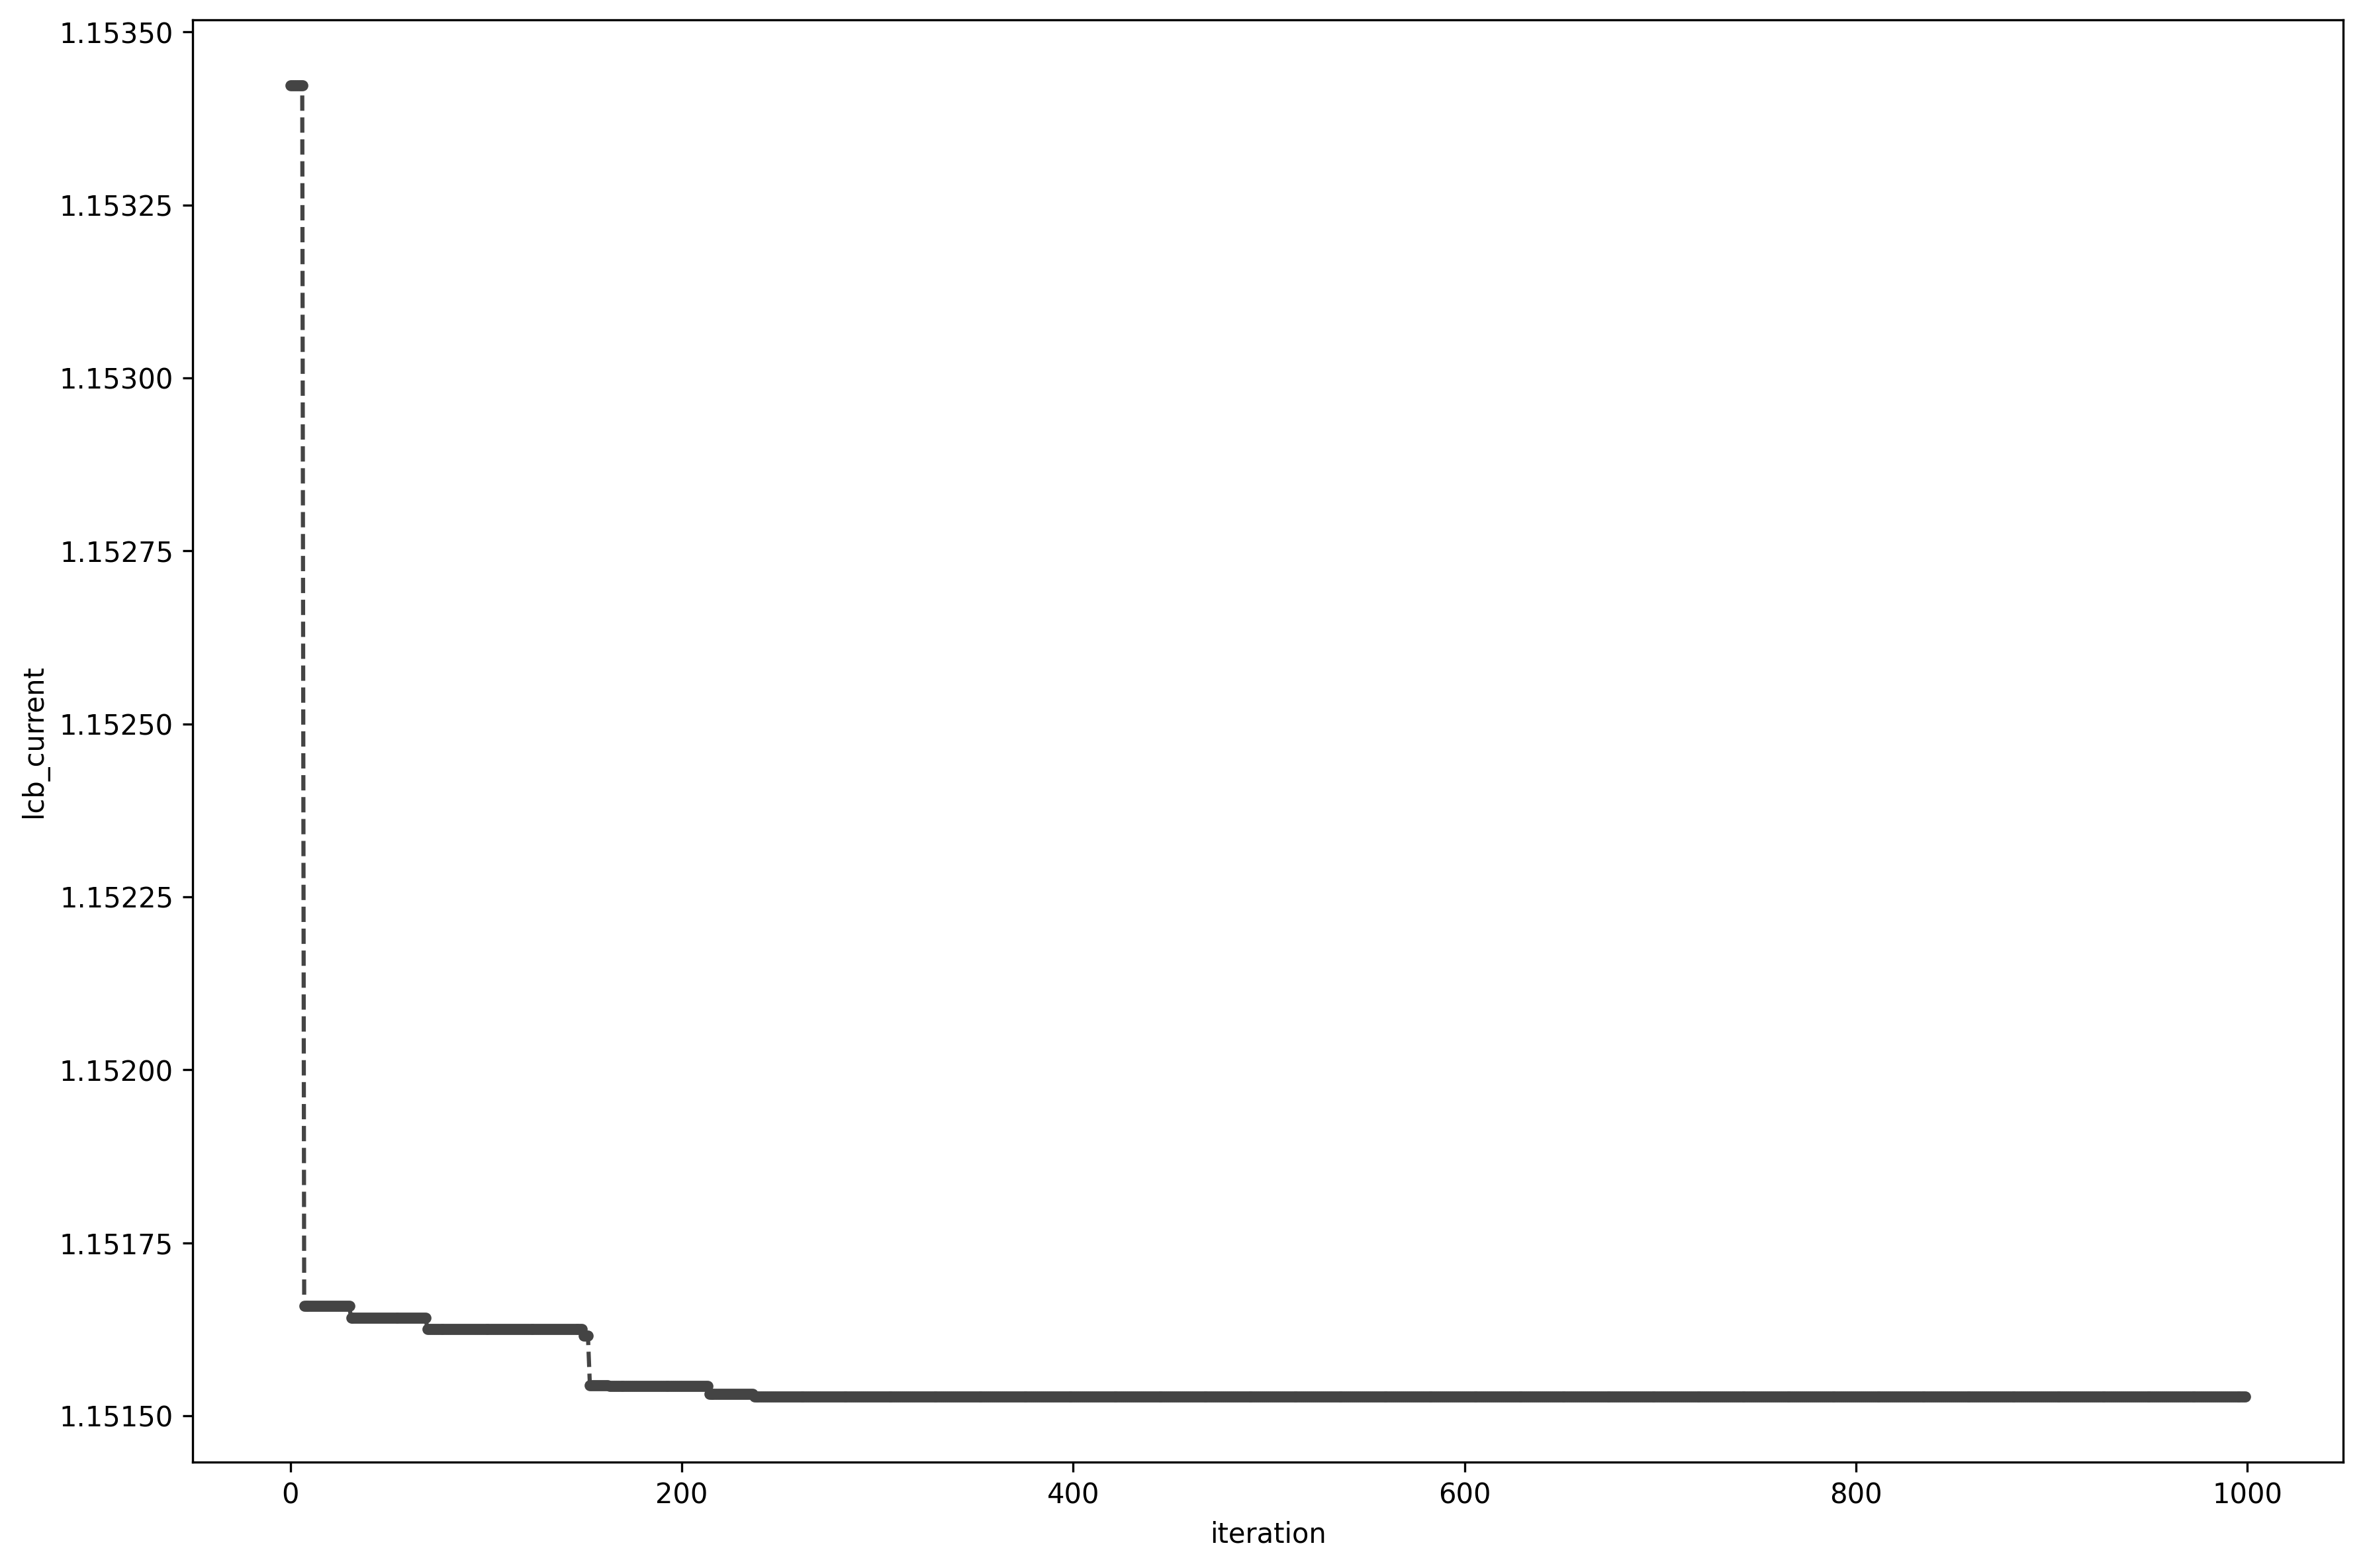

In [71]:
plt.figure(figsize=(12,8))
plt.plot(trace, '.--', color=e4e.color_1)
plt.xlabel('iteration')
plt.ylabel('lcb_current')
plt.tight_layout()
plt.show()

#### A complete Bayesian optimization

In [76]:
# Bayesian optimizer
class BayesianOptimizer:
    def __init__(self, num_parameters):
        self.num_parameters = num_parameters 
        self.parameters = []
        self.measurements = []
        self.x0 = np.array([0.5]*num_parameters)            # initialize at center of [0,1]

    def ask(self):                                          # generate next experiment parameter to measure
        if len(self.measurements) == 0:                     # initial run
            return self.x0 
        return self.new_parameter()
    
    def new_parameter(self):                               # search for lcb-minimizing parameter
        gpr = GPR4(
            self.parameters,
            self.measurements,
            sigma=0.15,                                     # response surface function
        )                                                   
        return random_search(gpr, self.num_parameters)[0]   # random search for next parameter to measure
    
    def tell(self, parameter, measurement):                 # store latest parameter and measurement
        self.parameters.append(parameter)
        self.measurements.append(measurement)

In [88]:
np.random.seed(7)
bo = BayesianOptimizer(num_parameters=7)
trace = []
min_time = np.inf
opt_parameter = None
for _ in range(48):
    parameter = bo.ask()                                    # random search for next parameter to measure
    cpu_time = jit_plus_server(parameter)                   # measure at this parameter
    bo.tell(parameter, cpu_time)                            # store the parameter and measurement
    trace.append(cpu_time)                                  # measureent per iteration
    if cpu_time < min_time:
        min_time = cpu_time
        opt_parameter = parameter
print(min_time)

1.0022660975684086


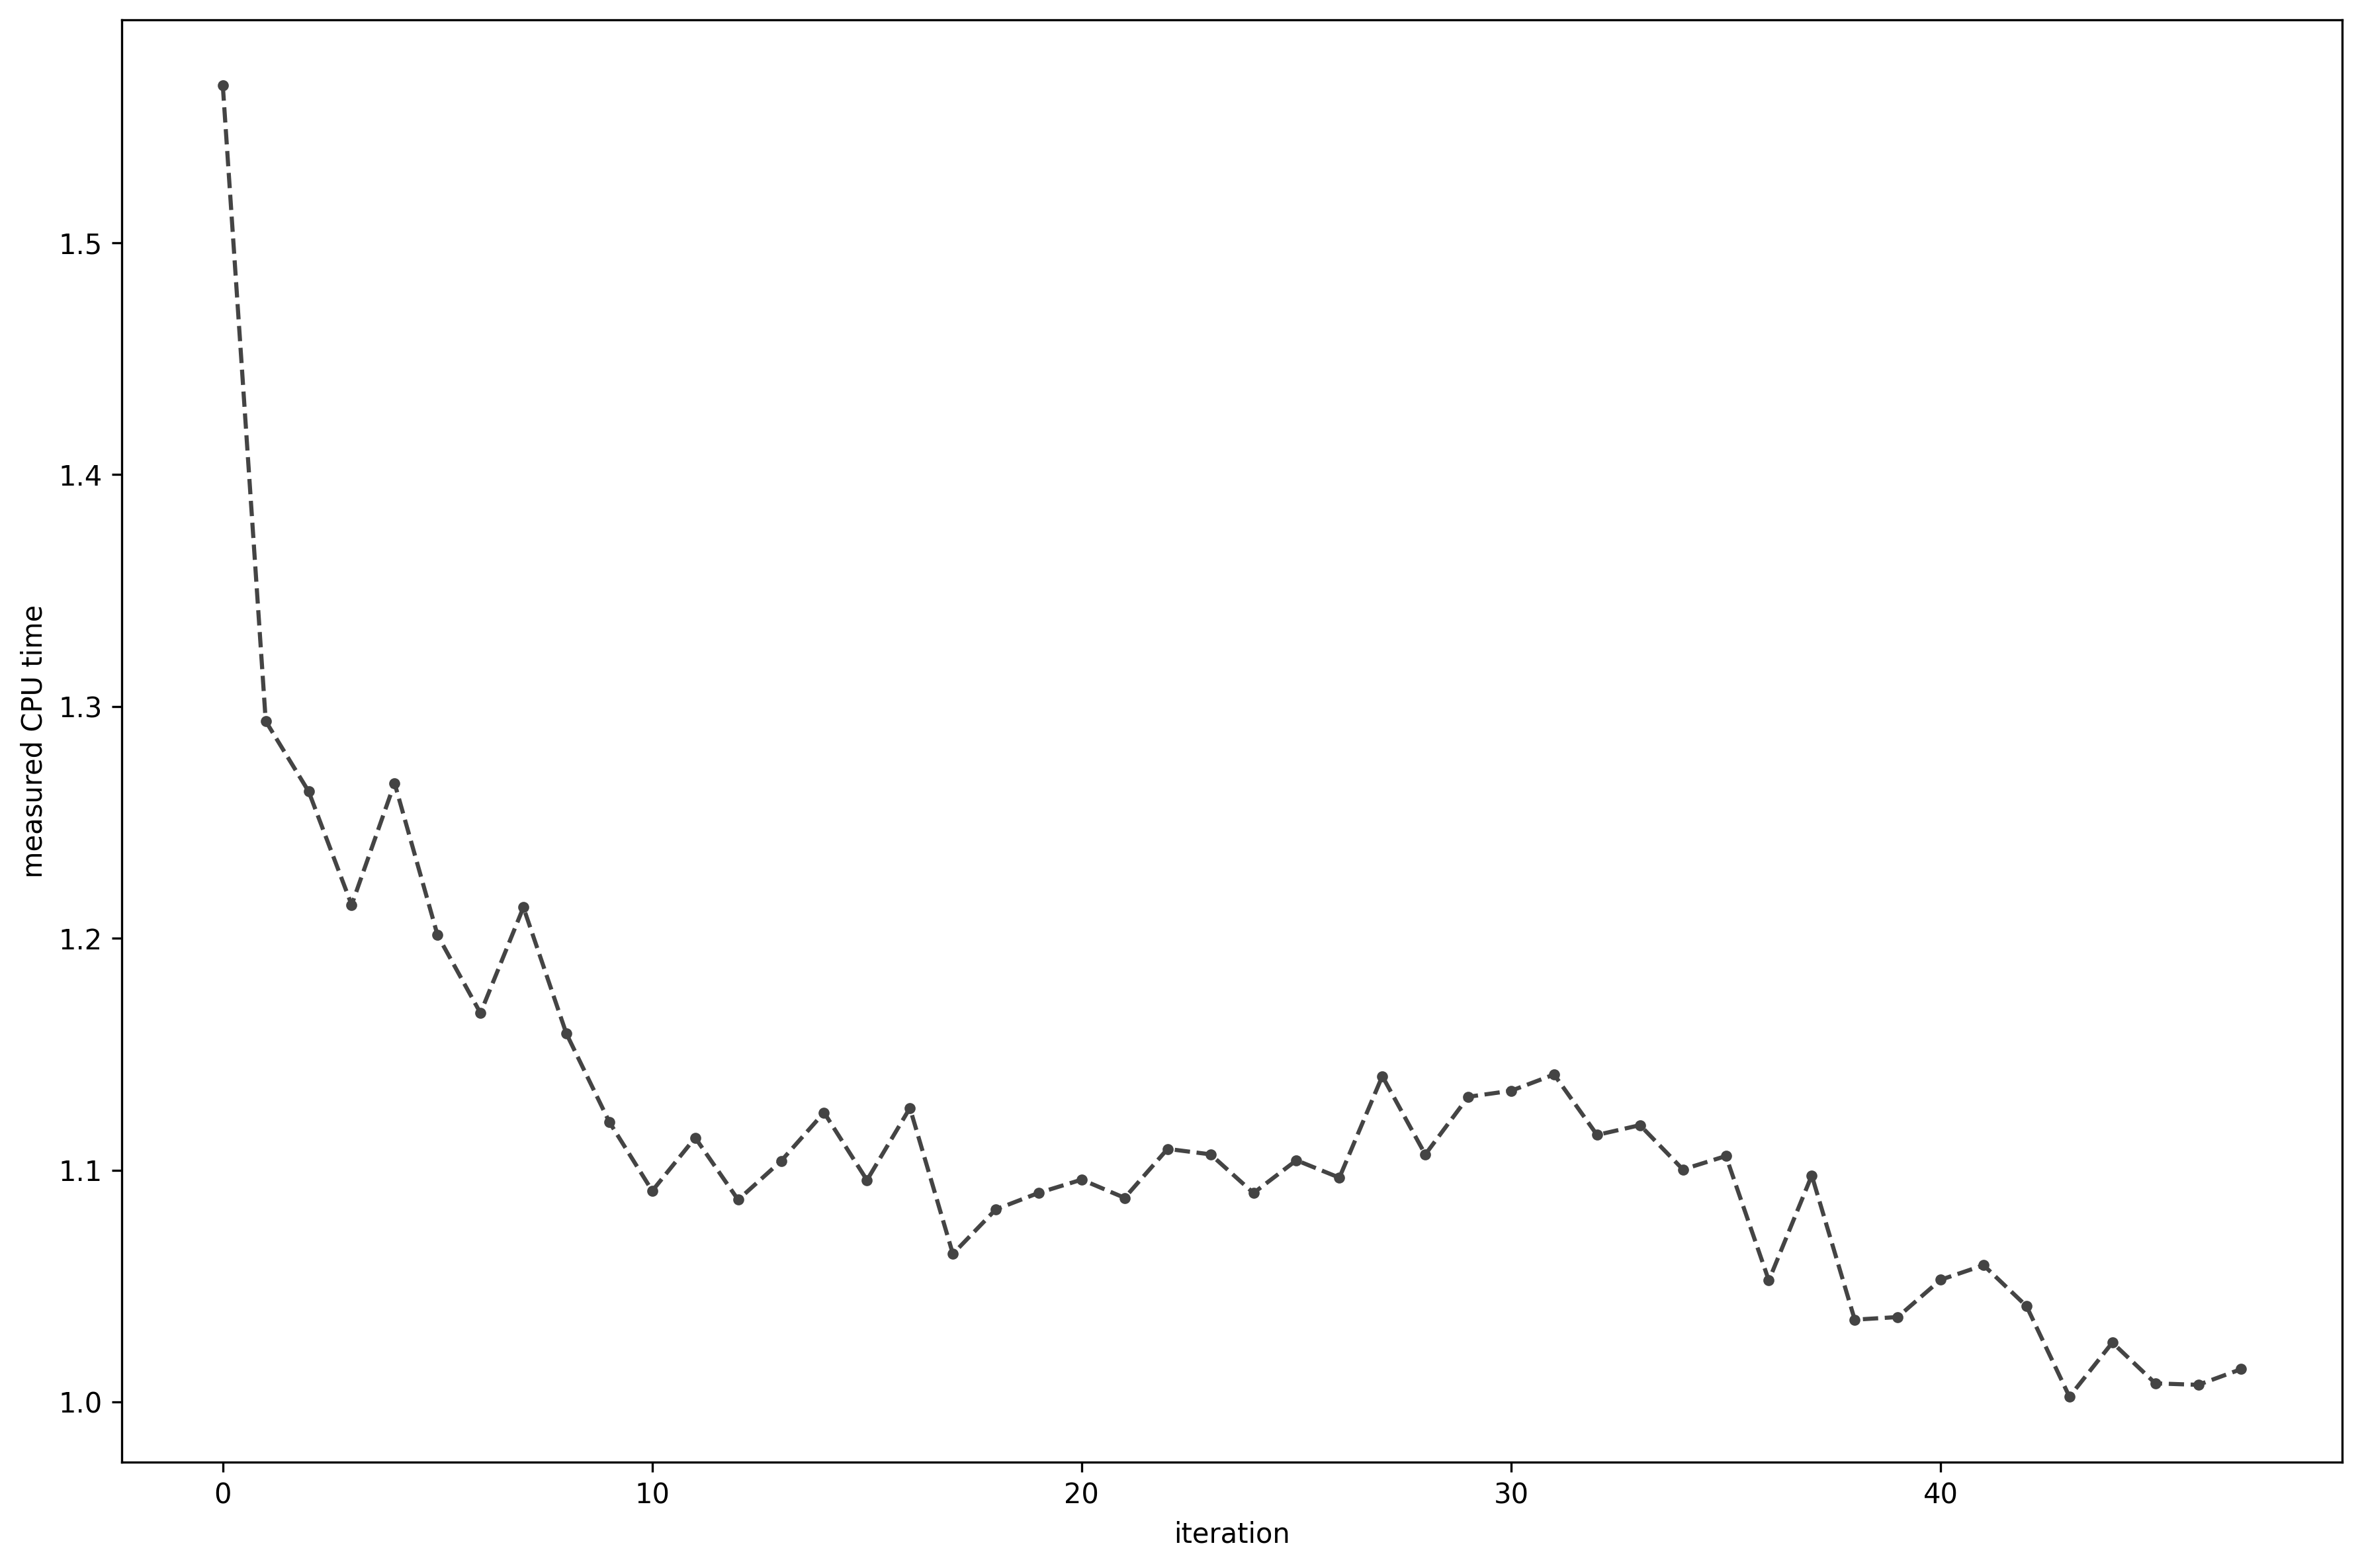

In [89]:
plt.figure(figsize=(12,8))
plt.plot(trace, '.--', color=e4e.color_1)
plt.xlabel('iteration')
plt.ylabel('measured CPU time')
plt.tight_layout()
plt.show()

In [90]:
min_time

1.0022660975684086

In [91]:
opt_parameter

array([0.13606832, 0.19342167, 0.13013743, 0.19785516, 0.13846727,
       0.21751408, 0.16760665])